<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Computation**

#### **IonQ**

##### *Libraries and Setup*

In [ ]:
!pip install cirq-ionq -q

In [ ]:
import cirq_ionq # https://docs.ionq.com/sdks/cirq
import cirq      # https://quantumai.google/cirq/hardware/ionq/circuits

In [ ]:
print(f"Cirq version: {cirq.__version__}")
print(f"Cirq-IonQ version: {cirq_ionq.__version__}")

Cirq version: 1.6.1
Cirq-IonQ version: 1.6.1


In [ ]:
import json
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files
from collections import Counter
import matplotlib.pyplot as plt
import cirq_ionq.ionq_exceptions as ionq_exceptions

##### *Connect to IonQ and Devices*

In [ ]:
# Connect to IonQ Service and Secret Manager for Token
from google.colab import userdata
api_token = userdata.get('ionq-quantum')
service = cirq_ionq.Service(api_key=api_token)

In [ ]:
# Check Available Backends (Simulators and QPUs) --> https://cloud.ionq.com/backends/qpus

headers = {"Authorization": f"apiKey {'ionq-quantum'}"}
r = requests.get("https://api.ionq.co/v0.3/backends", headers=headers)
if r.status_code == 200:
    for i, b in enumerate(r.json(), 1):
        qt = b.get('average_queue_time', 0)
        print(f"\n{i}. {b['backend'].upper()}\n └── Type: {'QPU' if 'qpu' in b['backend'] else 'Simulator'}\n └── Status: {b['status'].upper()}\n └── Qubits: {b['qubits']}\n └── Average Queue Time: {f'{qt/3600:.1f} hours' if qt > 3600 else f'{qt/60:.1f} minutes' if qt > 60 else f'{qt} seconds'}" + (''.join([f"\n └── Available Noise Models: {', '.join(b['noise_models'])}" if 'noise_models' in b else "", f"\n └── Characterization: Available" if 'characterization_url' in b else "", f"\n └── DEGRADED SERVICE" if b.get('degraded', False) else ""])))
else: print(f"Backend check failed: {r.status_code}\nError details: {r.text}")


1. QPU.HARMONY
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 11
 └── Average Queue Time: 0 seconds

2. QPU.ARIA-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 25
 └── Average Queue Time: 3981.8 hours
 └── Characterization: Available

3. QPU.ARIA-2
 └── Type: QPU
 └── Status: RETIRED
 └── Qubits: 25
 └── Average Queue Time: 0 seconds
 └── Characterization: Available

4. SIMULATOR
 └── Type: Simulator
 └── Status: AVAILABLE
 └── Qubits: 29
 └── Average Queue Time: 0 seconds
 └── Available Noise Models: aria-1, harmony, ideal

5. QPU.FORTE-1
 └── Type: QPU
 └── Status: AVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 50198.5 hours
 └── Characterization: Available

6. QPU.FORTE-ENTERPRISE-1
 └── Type: QPU
 └── Status: UNAVAILABLE
 └── Qubits: 36
 └── Average Queue Time: 11979.8 hours
 └── Characterization: Available


In [ ]:
# https://quantumai.google/cirq/hardware/ionq/calibrations
calibration = service.get_current_calibration()

In [ ]:
print(calibration.fidelities())

In [ ]:
print(calibration.timings())

##### *Use Case*

**Use Case: Two-Qubit Entangled [Bell State](https://en.wikipedia.org/wiki/Bell_state) Preparation $|\Phi^+\rangle$**

* Start with two qubits, $q_0$ and $q_1$, both initialized to the $|0\rangle$ state, creating the state **$|00\rangle$**.

* Hadamard gate puts $q_0$ into a **superposition**, meaning it is equally likely to be measured as $|0\rangle$ or $|1\rangle$.
  * Hadamard on the first qubit $q_0$:  $|00\rangle \xrightarrow{H \otimes I} \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes |0\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$
  * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$

* CNOT gate for **Entanglement** (using $q_0$ as the control and $q_1$ as the target): CNOT flips $q_1$ only if $q_0$ is $|1\rangle$  
    * If $q_0$ is $|0\rangle$, $q_1$ stays $|0\rangle$ (path $|00\rangle \to |00\rangle$).
    * If $q_0$ is $|1\rangle$, $q_1$ flips from $|0\rangle$ to $|1\rangle$ (path $|10\rangle \to |11\rangle$).
    * $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle) \xrightarrow{\text{CNOT}} \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$
    * The state becomes $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) = |\Phi^+\rangle$

This final state, $|\Phi^+\rangle$, is a maximally *entangled Bell state* $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ because measuring $q_0$ instantly determines $q_1$:with each outcome ('00' or '11') occurring with a $\mathbf{50\%}$ probability.
* The amplitude for $|00\rangle$ is $1/\sqrt{2}$. The probability $P('00') = |1/\sqrt{2}|^2 = 0.5$
* The amplitude for $|11\rangle$ is $1/\sqrt{2}$. The probability $P('11') = |1/\sqrt{2}|^2 = 0.5$

In [ ]:
# Define Circuit - Two-Qubit Bell state Preparation |Φ+⟩
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='x'))
print(circuit)

0: ───H───@───M('x')───
          │   │
1: ───────X───M────────


##### *Simulations*

In [ ]:
# Theoretical Calculation (Exact probability distribution based on state vector simulation)
def calculate_exact_noiseless_probabilities(circuit: cirq.Circuit) -> dict:

    # 1. Circuit Preparation and Measurement Removal
    """
    The purpose of a state vector simulation is to find the final quantum state before
    the measurement operation collapses it. Removing the terminal cirq.measure gate ensures
    the simulator provides the final superposition state |Φ⁺⟩
    """
    circuit_without_measurements = cirq.drop_terminal_measurements(circuit)

    # 2. State Vector Simulation
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit_without_measurements)
    final_state_vector = result.final_state_vector

    exact_counts = {}

    # 3. Probability and Count Calculation
    for i, amplitude in enumerate(final_state_vector):
        probability = np.abs(amplitude)**2
        count = round(probability * 100)  # Convert to counts for number of shots ('repetitions=')

    # 4. Result Mapping
        if count > 0:
            exact_counts[i] = count  # Use integer key like {0: 50, 3: 50}
    return exact_counts
theoretical_prediction = calculate_exact_noiseless_probabilities(circuit)

print("--- Theoretical Count Distribution ---")
print(f"Counter({theoretical_prediction})")
theoretical_counter = Counter(theoretical_prediction) # mock counter object to match format

# Store results for later comparison
with open('theoretical_result.pkl', 'wb') as f:
    pickle.dump(theoretical_counter, f)

--- Theoretical Count Distribution ---
Counter({0: 50, 3: 50})


In [ ]:
# Noiseless simulation
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noiseless Cirq Simulation")
print(result.histogram(key='x'))
print(result)
with open('noiseless_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({3: 53, 0: 47})
x=1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110, 1101101100010001011111001101111100111001101101101110001000110010100101000000011111101001100110100110


In [ ]:
# Noisy simulation
# https://docs.ionq.com/guides/simulation-with-noise-models
result = service.run(
    circuit=circuit,
    target="simulator",
    repetitions=100,
    name="Noisy Cirq Simulation",
    extra_query_params={"noise": {"model": "forte-1"}})
print(result.histogram(key='x'))
print(result)
with open('noisy_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 56, 3: 43, 2: 1})
x=0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111010011000, 0100101101100001110001000100001001101010011000010011010001101101100100100001010110110101111000011000


In [ ]:
# Quantum Simulation
# (https://docs.ionq.com/guides/qpu-submission-checklist)
job = service.create_job(
    circuit=circuit,
    target="qpu.forte-1", # forte-enterprise-1, aria-1
    repetitions=100,
    name="QPU Cirq Simulation")
print(job.job_id())
print(job.status())

019a7d6c-a0fb-779b-9340-8795a9a2f1c0
submitted


In [ ]:
# See job queue: https://cloud.ionq.com/jobs
job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
print(job.status())

completed


In [ ]:
# Retrieve a job
#job_id = "019a7d6c-a0fb-779b-9340-8795a9a2f1c0"
#job = service.get_job(job_id)

# Get the first result from the list
results_list = job.results()
result = results_list[0].to_cirq_result()  # Access first element
print(result.histogram(key='x'))
# Save results into file
with open('quantum_result.pkl', 'wb') as f:
    pickle.dump(result, f)

Counter({0: 55, 3: 43, 1: 1, 2: 1})


##### *Results and Interpretation*


RESULTS:
 State Binary  Theory  Noiseless  Noisy  Quantum
     0     00      50         47     56       55
     1     01       0          0      0        1
     2     10       0          0      1        1
     3     11      50         53     43       43



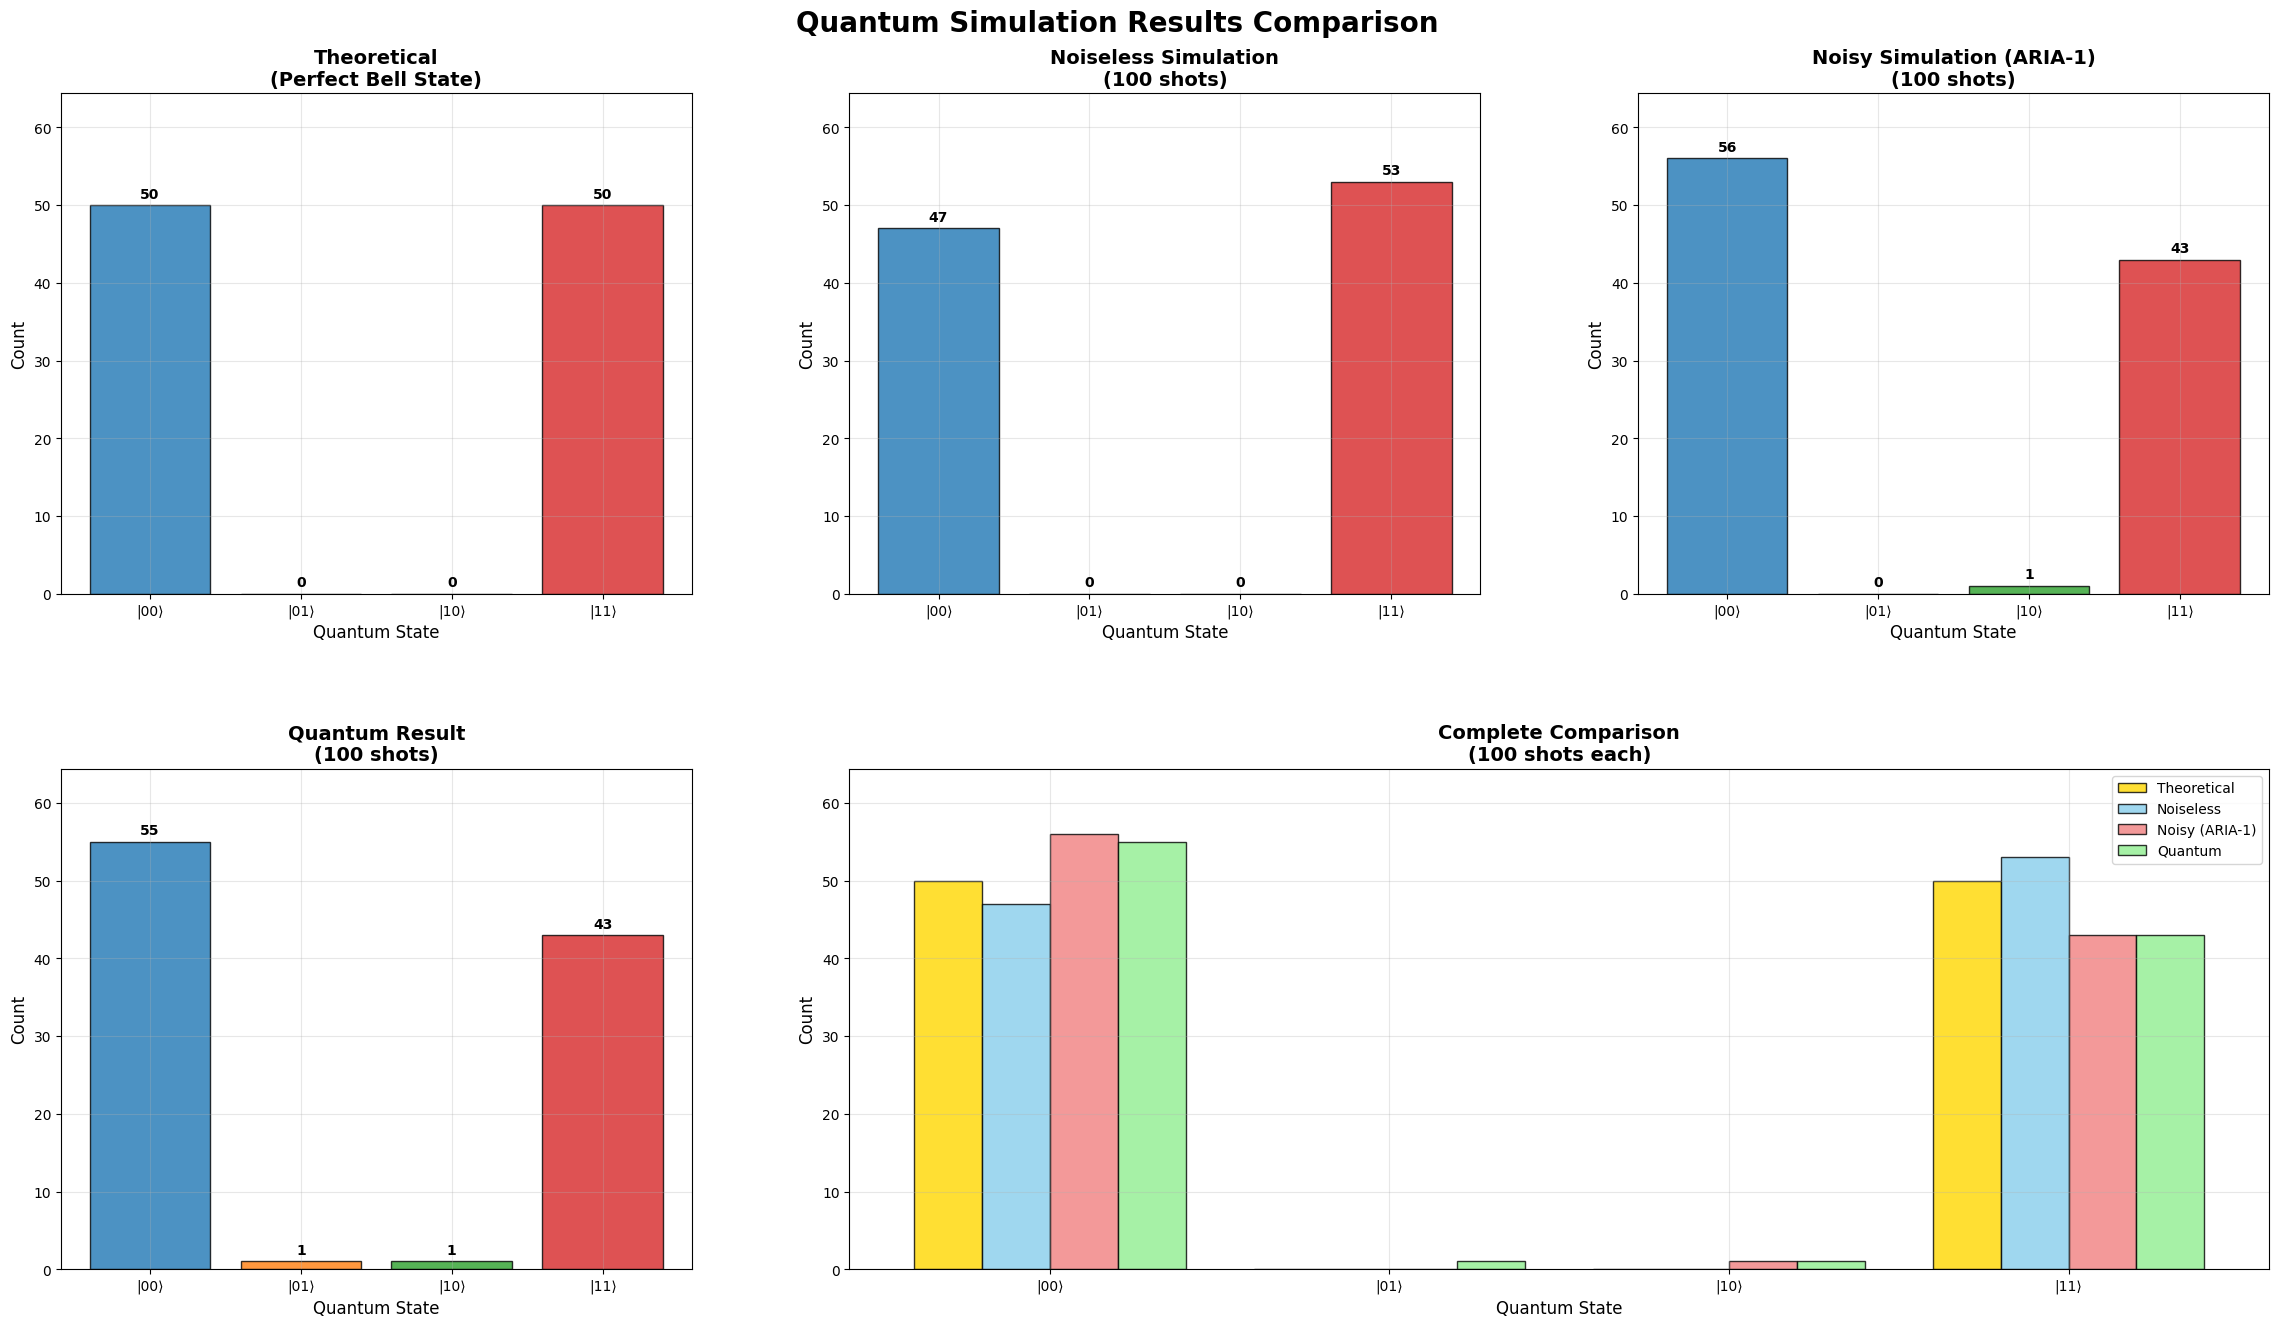

In [ ]:
# @title Comparison of Results
data = {}
for name in ['noiseless', 'noisy', 'theoretical', 'quantum']:
    with open(f'{name}_result.pkl', 'rb') as f:
        result = pickle.load(f)
        data[name] = result.histogram(key='x') if hasattr(result, 'histogram') else result

# Create comparison DataFrame
states = range(4)
comparison_df = pd.DataFrame({
    'State': states,
    'Binary': [format(s, '02b') for s in states],
    'Theory': [data['theoretical'].get(s, 0) for s in states],
    'Noiseless': [data['noiseless'].get(s, 0) for s in states],
    'Noisy': [data['noisy'].get(s, 0) for s in states],
    'Quantum': [data['quantum'].get(s, 0) for s in states]
})

print("\nRESULTS:\n" + "="*50)
print(comparison_df.to_string(index=False))
print("="*50 + "\n")

# Plotting
fig = plt.figure(figsize=(24, 14))
fig.suptitle('Quantum Simulation Results Comparison', fontsize=20, fontweight='bold', y=0.98)

state_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plot_configs = [
    (1, 'Theory', 'Theoretical\n(Perfect Bell State)'),
    (2, 'Noiseless', 'Noiseless Simulation\n(100 shots)'),
    (3, 'Noisy', 'Noisy Simulation (ARIA-1)\n(100 shots)'),
    (4, 'Quantum', 'Quantum Result\n(100 shots)')
]

max_count = comparison_df[['Theory', 'Noiseless', 'Noisy', 'Quantum']].max().max()

# Individual plots
for idx, col, title in plot_configs:
    ax = plt.subplot(2, 3, idx)
    bars = ax.bar(state_labels, comparison_df[col], color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Quantum State', fontsize=12)
    ax.set_ylim(0, max_count * 1.15)
    ax.grid(True, alpha=0.3)

    # Add count labels
    for bar, count in zip(bars, comparison_df[col]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01,
                f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Comparison plot
ax5 = plt.subplot(2, 3, (5, 6))
x = np.arange(4)
width = 0.2
plot_data = [
    ('Theory', 'Theoretical', 'gold'),
    ('Noiseless', 'Noiseless', 'skyblue'),
    ('Noisy', 'Noisy (ARIA-1)', 'lightcoral'),
    ('Quantum', 'Quantum', 'lightgreen')
]

for i, (col, label, color) in enumerate(plot_data):
    ax5.bar(x + (i-1.5)*width, comparison_df[col], width, label=label,
            color=color, alpha=0.8, edgecolor='black')

ax5.set_title('Complete Comparison\n(100 shots each)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Count', fontsize=12)
ax5.set_xlabel('Quantum State', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(state_labels)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, max_count * 1.15)

plt.subplots_adjust(left=0.06, bottom=0.08, right=0.98, top=0.92, wspace=0.25, hspace=0.35)
plt.show()

#### **IBM with Qiskit**

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit[visualization] -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [ ]:
## 1. Connect to IBM Quantum
api_token = userdata.get('ibm-quantum')

# Pass both the token and the channel
service = QiskitRuntimeService(channel='ibm_quantum_platform', token=api_token)

backend = service.least_busy(simulator=False, operational=True)
print(f"Selected backend: {backend.name}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-24 14:58:30,762: Default instance not set. Searching all available instances.


Selected backend: ibm_brussels



Ideal Circuit Diagram:


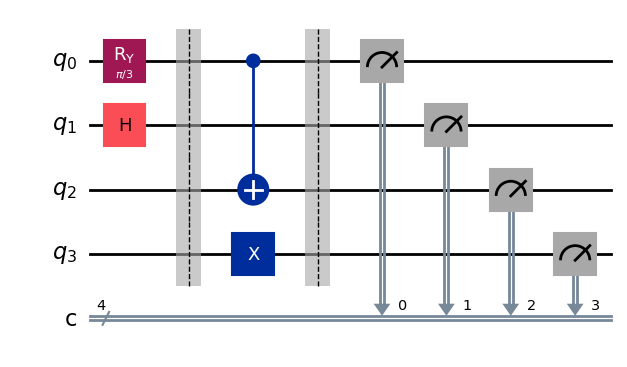

In [ ]:
# 2. Create the Quantum Circuit with Asymmetric State Evolution (with Unequal Superposition)
qc = QuantumCircuit(4, 4)
qc.ry(np.pi / 3, 0) # Replace H(0) with Ry(pi/3, 0) to create a 75%/25% split
qc.h(1)             # Keep the H on q1 for a 50/50 split
qc.barrier()
qc.cx(0, 2)
qc.x(3)
qc.barrier()
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
print("\nIdeal Circuit Diagram:")
display(qc.draw("mpl"))


Transpiled Circuit for ibm_brussels:


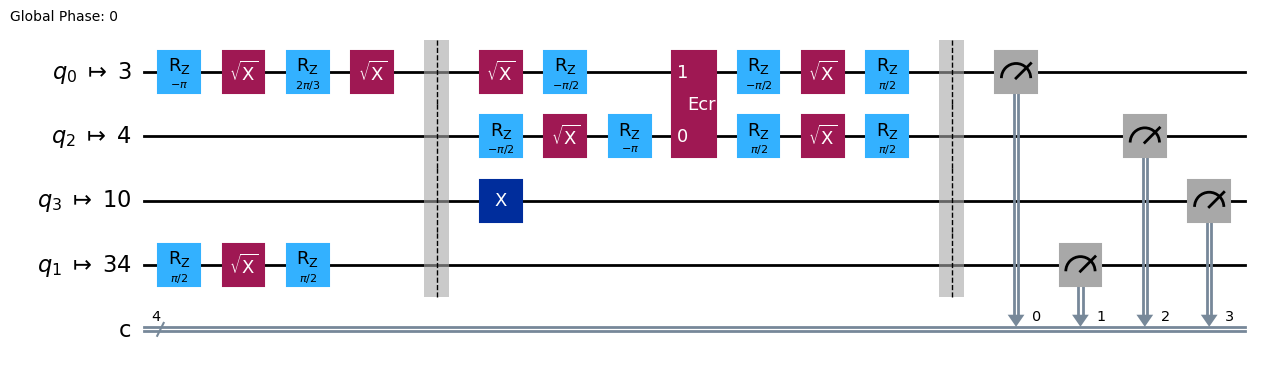

In [ ]:
# 3. Transpile circuit for backend (translates ideal circuit into one the hardware can run)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
print(f"\nTranspiled Circuit for {backend.name}:")
display(isa_circuit.draw("mpl"))

In [ ]:
# 4. Run job on IBM quantum computer
sampler = Sampler(mode=backend)
shots = 1024
print(f"\nSubmitting job to {backend.name}...")
job = sampler.run(pubs=[(isa_circuit,)], shots=shots) # Run transpiled 'isa_circuit', not original 'qc'
print(f"Job submitted successfully! Job ID: {job.job_id()}")


Submitting job to ibm_brussels...
Job submitted successfully! Job ID: d3615tl7ibtc73dlifgg


In [ ]:
job.status()

'DONE'

In [ ]:
job.metrics()

{'timestamps': {'created': '2025-09-18T14:11:02.899474Z',
  'finished': '2025-09-18T14:15:53.524337Z',
  'running': '2025-09-18T14:15:36.902052Z'},
 'bss': {'seconds': 3},
 'usage': {'quantum_seconds': 3, 'seconds': 3},
 'qiskit_version': 'qiskit_ibm_runtime-0.41.1,qiskit-2.1.2*',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

In [ ]:
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-09-18 14:15:51', stop='2025-09-18 14:15:53', size=1024>)])}, 'version': 2})


Measurement Results (Counts):
{'1000': 390, '1010': 350, '1101': 121, '1110': 4, '1111': 141, '0010': 4, '0111': 2, '1001': 1, '1100': 5, '1011': 2, '0101': 1, '0000': 3}

Result Histogram:


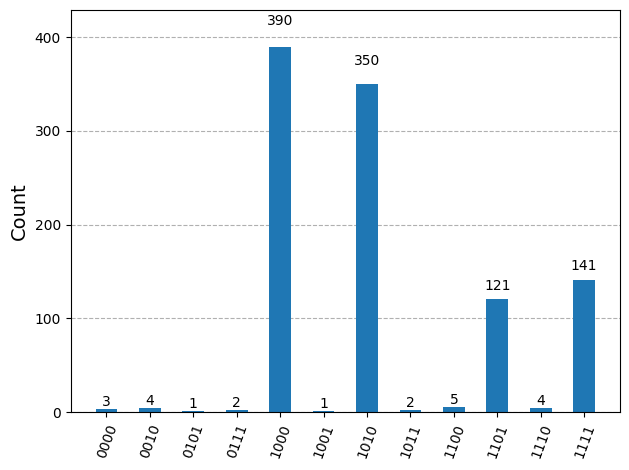

In [ ]:
# 5. Get and display results
result = job.result()
counts = result[0].data.c.get_counts()
print("\nMeasurement Results (Counts):")
print(counts)
plot_histogram(counts)


Local Simulation results (counts) with 1024 shots:
{'1101': 118, '1111': 131, '1000': 388, '1010': 387}

Local Simulation Probabilities:
  |1000>: 0.379 (388/1024)
  |1010>: 0.378 (387/1024)
  |1101>: 0.115 (118/1024)
  |1111>: 0.128 (131/1024)

Local Simulation Histogram:


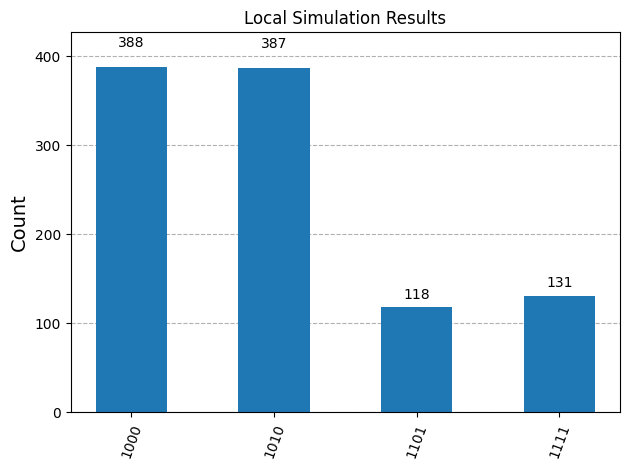

In [ ]:
# Appendix: Run local simulation
from qiskit.primitives import StatevectorSampler as LocalSampler
from qiskit.visualization import plot_histogram

local_sampler = LocalSampler() # Create local sampler
local_shots = 1024
local_job = local_sampler.run(pubs=[(qc,)], shots=local_shots) # Run circuit
local_result = local_job.result()
local_counts = local_result[0].data.c.get_counts() # Extract counts from result
print(f"\nLocal Simulation results (counts) with {local_shots} shots:")
print(local_counts)
print("\nProbabilities:")
for bitstring, count in sorted(local_counts.items()):
    probability = count / local_shots
    print(f"  |{bitstring}>: {probability:.3f} ({count}/{local_shots})")

display(plot_histogram(local_counts, title="Local Simulation Results"))

Devices: https://eu-de.quantum.cloud.ibm.com/computers

Topology: https://eu-de.quantum.cloud.ibm.com/docs/de/guides/qpu-information

Jobs: https://eu-de.quantum.cloud.ibm.com/workloads

Cost: https://cloud.ibm.com/billing

Tutorials: https://eu-de.quantum.cloud.ibm.com/docs/de/tutorials

#### **Chemistry**

###### *Select or Define Molecule*

In [ ]:
!pip install pyscf geometric periodictable qutip cirq openfermion openfermionpyscf -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize
import scipy.optimize
import cirq
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

In [ ]:
# Helium (He)
mol = gto.Mole()
mol.atom = '''
    He 0.00 0.00 0.00
'''
molecule = 'Helium (He)'

In [ ]:
# Hydrogen (H₂)
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''
molecule = 'Hydrogen (H₂)'

In [ ]:
# Oxygen (O₂)
mol = gto.Mole()
mol.atom = '''
    O  0.00 0.00  0.00
    O  0.00 0.00  1.21
'''
molecule = 'Oxygen (O₂)'

In [ ]:
# Water (H₂O)
mol = gto.Mole()
mol.atom = '''
    O  0.000000  0.000000  0.000000
    H  0.000000  0.757000  0.586000
    H  0.000000 -0.757000  0.586000
'''
molecule = 'Water (H₂O)'

In [ ]:
# Nitrous Oxide (N₂O)
mol = gto.Mole()
mol.atom = '''
    N  0.00000000  0.00000000  -1.25324312
    N  0.00000000  0.00000000  -0.12244312
    O  0.00000000  0.00000000   1.06565688
'''
molecule = 'Nitrous Oxide (N₂O)'

In [ ]:
# Carbon Dioxide (CO₂)
mol = gto.Mole()
mol.atom = '''
    C   0.0000000   0.0000000   0.0000000
    O   0.0000000   0.0000000   1.1600000
    O   0.0000000   0.0000000  -1.1600000
'''
molecule = 'Carbon Dioxide (CO₂)'

In [ ]:
# Ammonia (NH₃)
mol = gto.Mole()
mol.atom = '''
    N  0.0000  0.0000  0.2000
    H  0.0000  0.9433 -0.2000
    H  0.8165 -0.4717 -0.2000
    H -0.8165 -0.4717 -0.2000
'''
molecule = 'Ammonia (NH₃)'

In [ ]:
# Phosphine (PH₃)
mol = gto.Mole()
mol.atom = '''
    P   0.00000000   0.00000000   0.24580000
    H   1.21850000   0.00000000  -0.57350000
    H  -0.60925000   1.05520000  -0.57350000
    H  -0.60925000  -1.05520000  -0.57350000
'''
molecule = 'Phosphine (PH₃)'

In [ ]:
# Methane (CH₄)
mol = gto.Mole()
mol.atom = '''
    C  0.000000  0.000000  0.000000
    H  0.629118  0.629118  0.629118
    H -0.629118 -0.629118  0.629118
    H -0.629118  0.629118 -0.629118
    H  0.629118 -0.629118 -0.629118
'''
molecule = 'Methane (CH₄)'

In [ ]:
# Methyl Chloride (CH₃Cl)
mol = gto.Mole()
mol.atom = '''
    C   0.00000000   0.00000000   0.45520100
    Cl  0.00000000   0.00000000  -1.31979900
    H   0.00000000   1.02669100   0.82520000
    H   0.88910000  -0.51334500   0.82520000
    H  -0.88910000  -0.51334500   0.82520000
'''
molecule = 'Methyl Chloride (CH₃Cl)'

In [ ]:
# Dimethyl Sulfide (DMS) (CH₃)₂S
mol = gto.Mole()
mol.atom = '''
    S   0.00000000   0.46519300   0.00000000
    C  -1.50853500  -0.34759700   0.00000000
    H  -1.48831900  -1.00619800   0.87783900
    H  -1.48831900  -1.00619800  -0.87783900
    H  -2.45862400   0.18760200   0.00000000
    C   1.50853500  -0.34759700   0.00000000
    H   1.48831900  -1.00619800   0.87783900
    H   2.45862400   0.18760200   0.00000000
    H   1.48831900  -1.00619800  -0.87783900
'''
molecule = 'Dimethyl Sulfide (DMS) (CH₃)₂S'

In [ ]:
# Dimethyl Disulfide (DMDS) (CH₃S)₂
mol = gto.Mole()
mol.atom = '''
    C  -1.579679   0.849405  -0.177006
    H  -1.516541   1.264210   0.829033
    H  -2.529898   0.315926  -0.297427
    H  -1.554032   1.528773  -1.031526
    S  -0.288210  -0.528464  -0.126027
    S   0.887210   0.334360   0.941620
    C   2.276901  -0.755146   0.505299
    H   2.331268  -1.526279   1.272183
    H   3.176472  -0.144865   0.413156
    H   2.199446  -1.196144  -0.487140
'''
molecule = 'Dimethyl Disulfide (DMDS) (CH₃S)₂'

In [ ]:
# Benzene (C₆H₆)
mol = gto.Mole()
mol.atom = '''
    C    0.000000    1.396763    0.000000
    C    1.209587    0.698382    0.000000
    C    1.209587   -0.698382    0.000000
    C    0.000000   -1.396763    0.000000
    C   -1.209587   -0.698382    0.000000
    C   -1.209587    0.698382    0.000000
    H    0.000000    2.480310    0.000000
    H    2.146325    1.240155    0.000000
    H    2.146325   -1.240155    0.000000
    H    0.000000   -2.480310    0.000000
    H   -2.146325   -1.240155    0.000000
    H   -2.146325    1.240155    0.000000
'''
molecule = 'Benzene (C₆H₆)'

In [ ]:
# Femoco Fe₄S₄ (Simplified Cube Model)
"""
Low Computational Cost. Fe₄S₄ clusters are common in biology (ferredoxins) and share basic Fe−S framework of FeMoco.
Lacks full MoFe₇ score, crucial Mo atom, central C atom, and all ligands.
Cannot accurately model unique electronic and magnetic properties or the catalytic function of the true FeMoco.
"""
mol = gto.Mole()
mol.atom = '''
    Fe   1.360   1.360   1.360
    Fe  -1.360  -1.360   1.360
    Fe  -1.360   1.360  -1.360
    Fe   1.360  -1.360  -1.360
    S   -2.280   0.000   0.000
    S    2.280   0.000   0.000
    S    0.000  -2.280   0.000
    S    0.000   2.280   0.000
'''
molecule = 'Femoco Fe₄S₄ (Simplified Cube Model)'
# Choose later mol.basis = 'lanl2dz'

In [ ]:
# FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)
"""
FeMoco MoFe₇S₉C coordinates extracted from PDB 3U7Q (nitrogenase).
PDB 3U7Q is the entry code in the Protein Data Bank (PDB) for the atomic-resolution structure
of the nitrogenase Molybdenum-Iron (MoFe) protein from the bacterium Azotobacter vinelandii.

High Accuracy: uses experimentally derived coordinates (PDB 3U7Q), all essential metal (Mo, Fe) and bridging non-metal (S, C) atoms.
Modeling Active Site: It is minimal structure needed to capture the unique electronic and magnetic properties of FeMoco itself.
Limitations: still omits important protein-derived ligands (like homocitrate, histidine, and cysteine residues) that stabilize
the cluster and affect its electronic environment. It is also computationally demanding due to its size (MoFe₇S₉C).
"""
mol = gto.Mole()
mol.atom = '''
    Fe   2.832   0.521   0.234
    Fe   0.696   2.290   0.871
    Fe   0.590  -0.002   1.995
    Fe  -0.623   0.031  -0.384
    Fe   1.446  -1.731  -0.265
    Fe  -0.753  -2.181   0.879
    Fe  -1.076  -0.021  -2.830
    Mo  -2.851   0.046  -0.493
    S    1.218   0.512   0.158
    S   -0.887   1.980   0.543
    S    2.382  -0.015  -1.774
    S    0.928  -1.975  -2.202
    S   -1.172  -0.322  -4.669
    S   -2.379  -0.485   1.764
    S   -0.931  -2.028   2.816
    S    1.145  -2.058   1.674
    S    2.626   2.254   1.455
    C    0.027  -0.018  -0.008
'''
molecule = 'FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)'

In [ ]:
# FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)
 # FeMoco with homocitrate ligand (more complete model)
"""
MoFe₇S₉C core with an added ligand proxy. The coordinates suggest the N atom is likely a simplified placeholder for the N
from the histidine (His) or homocitrate (h-citrate) ligand, which coordinates to the Mo atom.

This model attempts to account for the crucial ligand field effects from the surrounding protein environment without having
to include the entire protein (∼100,000 atoms).

The homocitrate ligand (represented by the 'N' in simplified list) is critical for FeMoco's stability and function.
Including its effect is vital for studying the catalytic cycle or reaction mechanism (e.g., substrate binding).

Computational trade-off: It is slightly larger and more expensive than MoFe₇S₉C, but it provides a more chemically complete description
for studying reactivity. mol.spin=0 and mol.charge=−3 also indicates attempt to model a specific, stable electronic state of biological system.
"""
mol = gto.Mole()
mol.atom = '''
    Mo  -3.446  -0.037  -0.011
    Fe  -1.164  -0.945  -1.371
    Fe  -0.983   1.637  -0.408
    Fe  -0.970  -0.406   1.646
    Fe   1.017   0.442  -1.605
    Fe   0.997  -1.635   0.444
    Fe   1.200   0.942   1.357
    Fe   3.431   0.028  -0.010
    S   -1.378   0.093  -3.219
    S   -2.656   1.799  -1.349
    S   -2.648  -1.885  -1.313
    S    0.788  -1.335  -2.447
    S   -2.625  -1.365   1.803
    S    0.751  -2.459   1.293
    S    2.669  -1.840   1.284
    S    2.685   1.877   1.316
    S    0.826   2.435  -1.311
    C    0.015  -0.003   0.006
    N   -5.312  -0.049  -0.018
'''
molecule = 'FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)'
# Choose later: mol.spin = 0 and mol.charge = -3 and

###### ***Choose Basis Set and Build Molecule***

In [ ]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'sto-3g'  # sto-3g, cc-pvdz, 6-31G, for transition metals: 'def2-svp', 'def2-tzvp', 'lanl2dz'
mol.ecp = False       # Set to = mol.basis for Femoco
mol.symmetry = True
mol.spin = False
mol.charge = False
#mol.verbose = 4
mol.build()

<font color="blue">*What Basis Set to choose?*

Basis sets are fundamental in quantum chemistry calculations (esp. Hartree-Fock, DFT, and post-Hartree-Fock MP2, CCSD). A basis set defines a set of functions to describe orbitals of atoms and molecules. These functions are combinations of Gaussian-type orbitals (GTOs) that approximate the behavior of electrons.

| **Basis Set**    | **Type**                    | **Usage**                                  |  |
|------------------|-----------------------------|--------------------------------------------|------------------------------------------------------------------|
| **STO-3G**       | Minimal Basis Sets                     | Low accuracy, speed is priority - ideal for large molecules, preliminary calculations <br>* Slater-Type Orbitals approximated by 3 Gaussians, uses smallest number of functions <br>$\,$ necessary to describe each orbital (one basis function per orbital)  <br>* Not ideal when electron correlation or polarization effects are important                      |
| **3-21G or 6-31G**| Split-Valence Basis Set                | Good compromise speed/accuracy - Good for medium-accuracy molecular calculations  <br>* Uses different number of Gaussian functions for core electrons (e.g., 3 or 6 Gaussians) versus valence electrons (e.g., 2 or 1 Gaussians). <br>* 6-31G describes core orbitals with 6 Gaussians and valence orbitals with a split basis (1 part described with 3 Gaussians, another with 1)  <br>* Good moderate-sized systems in general-purpose calculations  <br>* Does NOT account for polarization or diffuse effects (in more complex systems or anions)                          |
| **6-31G(d) or 6-31G(d,p)**     | Polarized Basis Sets      |  Good compromise speed/accuracy - for molecular geometries, vibrational frequency studies<br>* Add polarization functions, such as **d** or **p** orbitals, which allow electron density to adjust to molecular environment. <br>* 6-31G(d) adds d-type functions to atoms, improving the description of electron distributions. <br>* Polarized basis sets are essential for studying molecular geometries, vibrational frequencies, <br>$\,$ and reactions because they provide a better description of the electron cloud's flexibility.
| **def2-svp, def2-tzvp or lanl2dz**  | Split valence polarization Basis Set  | Special for Transition Metals like in FeMoco                 |              |
| **6-31+G or 6-31++G**       | Diffuse Basis Set            | Special for Anions, Excited States, Weakly bound electrons, Van der Waals force<br>* Adds diffuse functions (denoted by "+"): are functions with very small exponents to describe electrons far from the nucleus (e.g., anions or excited states). <br>* "++" refers to adding diffuse functions for both heavy atoms and hydrogen. <br>* Ideal for systems with loosely (weakly) bound electrons, such as anions, Rydberg states, and excited states.                    |
| **aug-cc-pVDZ or aug-cc-pVTZ**  | Augmented Correlation Basis Set  | Special for Anions, Excited States, Weakly bound electrons, Van der Waals force<br>* are correlation-consistent basis sets that include augmented diffuse functions <br>* Necessary for high-accuracy calculations with weakly bound electron systems (van der Waals interactions, anions, and excited states) <br>* Extreme accuracy but at significant computational cost                  |
| **cc-pVDZ, pVTZ, pVQZ**      | Correlation-Consistent (DZ) Basis Set | High-accuracy - Optimized for correlating electron pairs (in post-Hartree-Fock methodsMP2, CCSD).<br>* Large basis set, High-precision electron correlation, property studies and correlation calculations <br>* Designated double-zeta (DZ), triple-zeta (TZ), or quadruple-zeta (QZ), where a higher "zeta" value <br>$\,$ means more flexibility and a better description of the electron correlation.<br>* Commonly used in accurate wavefunction-based calculations MP2, CCSD(T), and coupled-cluster <br>* especially for high-precision studies of electronic correlation and molecular properties.  |








In [ ]:
# Details about the molecule
def print_molecule_info(mol):
    print("="*50)
    print(f"Molecule Summary for {molecule}")
    print("="*50)
    print(f"Atoms: {mol.natm}")
    print(f"Electrons: {mol.nelectron}")
    print(f" Alpha electrons: {mol.nelec[0]}")
    print(f" Beta electrons: {mol.nelec[1]}")
    print(f"Basis: {mol.basis}")
    print(f"Basis functions: {mol.nao}")
    print(f"Charge: {mol.charge}")
    print(f"Spin (2S): {mol.spin}")
    print(f"Multiplicity (2S+1): {mol.spin + 1}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc():.6f} Hartree")
    # Point group symmetry
    print(f"Top group: {mol.topgroup}")
    print(f"Group name: {mol.groupname}")
    print("\nAtom Coordinates (Angstrom):")
    for ia in range(mol.natm):
        symb = mol.atom_symbol(ia)
        coord = mol.atom_coord(ia) * 0.52917721067
        print(f"  {symb:2s}  {coord[0]:10.6f}  {coord[1]:10.6f}  {coord[2]:10.6f}")
    print("="*50)
print_molecule_info(mol)

Molecule Summary for Oxygen (O₂)
Atoms: 2
Electrons: 16
 Alpha electrons: 8
 Beta electrons: 8
Basis: sto-3g
Basis functions: 10
Charge: False
Spin (2S): False
Multiplicity (2S+1): 1
Nuclear repulsion energy: 27.989538 Hartree
Top group: Dooh
Group name: Dooh

Atom Coordinates (Angstrom):
  O     0.000000    0.000000    0.000000
  O     0.000000    0.000000    1.210000


###### *Static (No Nuclear Motion): Single-Point Energy Calculation: **Variational Quantum Eigensolver** (VQE)*

In [ ]:
# @title Quantum Ground State Calculation with UCCSD
import numpy as np
import scipy.optimize
import itertools
import cirq
from openfermion import MolecularData, FermionOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf
from pyscf import scf, dft, gto

# ==========================================
# 0. CONFIGURATION SWITCH
# ==========================================

# Choose your Ansatz here: 'UCCSD' or 'HEA' (Hardware Efficient, np.zeros + 0.01 initialization)
ANSATZ_TYPE = 'UCCSD'

# ==========================================
# 1. Classical Benchmarks (HF & DFT)
# ==========================================

print("="*50)
print(f"Ground State Calculation for {molecule}")
print("="*50)

print("\n--- Classical Benchmarks ---")

# Hartree-Fock
mf_hf = scf.RHF(mol)
mf_hf.verbose = 0
hf_energy = mf_hf.kernel()
print(f"Hartree-Fock Energy: {hf_energy:.6f} Ha")

# DFT (B3LYP)
mf_dft = dft.RKS(mol)
mf_dft.xc = 'B3LYP'
mf_dft.verbose = 0
dft_energy = mf_dft.kernel()
print(f"DFT (B3LYP) Energy:  {dft_energy:.6f} Ha")
print("-" * 30)

# ==========================================
# 2. Dynamic Bridge & Helpers
# ==========================================

def get_hamiltonian_from_mole(mol):
    """Bridging function: PySCF Mol -> OpenFermion QubitOperator"""
    n_atoms = mol.natm
    basis = mol.basis
    multiplicity = mol.spin + 1
    charge = mol.charge

    print(f"-> Bridging Molecule: {n_atoms} atoms, Basis: {basis}, Multiplicity: {multiplicity}")

    symbols = [mol.atom_symbol(i) for i in range(n_atoms)]
    coords = mol.atom_coords(unit='Angstrom')
    geometry = [[symbols[i], list(coords[i])] for i in range(n_atoms)]

    molecule_data = MolecularData(geometry, basis, multiplicity, charge)
    molecule_data = run_pyscf(molecule_data, run_scf=True)

    mh = molecule_data.get_molecular_hamiltonian()
    fh = get_fermion_operator(mh)
    qubit_hamiltonian = jordan_wigner(fh)

    return qubit_hamiltonian, molecule_data.n_qubits, molecule_data.n_electrons

def get_uccsd_excitations(n_orbitals, n_electrons):
    """Generates indices for Single and Double excitations."""
    occupied_indices = range(n_electrons)
    virtual_indices = range(n_electrons, n_orbitals)

    single_excitations = []
    double_excitations = []

    for i in occupied_indices:
        for a in virtual_indices:
            single_excitations.append((i, a))

    for i, j in itertools.combinations(occupied_indices, 2):
        for a, b in itertools.combinations(virtual_indices, 2):
            double_excitations.append((i, j, a, b))

    return single_excitations, double_excitations

# ==========================================
# 3. Ansatz Constructions
# ==========================================

def create_hea_ansatz(qubits, n_electrons, params):
    """Hardware Efficient Ansatz"""
    circuit = cirq.Circuit()
    # Init HF
    for i in range(n_electrons): circuit.append(cirq.X(qubits[i]))

    n_q = len(qubits)
    param_idx = 0

    # Layer 1: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1
    # Layer 2: CNOT
    for i in range(n_q - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    # Layer 3: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1

    return circuit

def create_uccsd_ansatz(qubits, n_electrons, params, excitations):
    """
    Unitary Coupled Cluster Singles and Doubles (UCCSD) Ansatz.
    """
    circuit = cirq.Circuit()

    # 1. Initial State: Hartree-Fock
    for i in range(n_electrons):
        circuit.append(cirq.X(qubits[i]))

    # 2. Evolutions for Excitations
    param_idx = 0

    for exc in excitations:
        theta = params[param_idx]

        # Generator Construction
        if len(exc) == 2: # Single: i -> a
            i, a = exc
            generator = FermionOperator(((a, 1), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (a, 0)), 1.0)
        elif len(exc) == 4: # Double: i,j -> a,b
            i, j, a, b = exc
            generator = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)), 1.0)

        # Jordan-Wigner & Evolution
        qubit_generator = jordan_wigner(generator)
        for term, coeff in qubit_generator.terms.items():
            # Map to Cirq Pauli String
            pauli_map = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}
            qubit_pauli_map = {qubits[idx]: pauli_map[p_str] for idx, p_str in term}
            pauli_string = cirq.PauliString(qubit_pauli_map)

            # --- FIX FOR MODERN CIRQ ---
            # We want exp(theta * coeff * P).
            # Since generator is anti-hermitian, coeff is imaginary.
            # Cirq's P**t implements exp(i * pi * t * P).
            # We match the exponents: i * pi * t = theta * coeff
            # t = (theta * coeff.imag) / pi

            exponent = (theta * coeff.imag) / np.pi
            circuit.append(pauli_string ** exponent)

        param_idx += 1

    return circuit

# ==========================================
# 4. Cost Function & VQE Execution
# ==========================================

print("\n--- Starting VQE Calculation ---")
print(f"Method Selected: {ANSATZ_TYPE}")

# A. Setup System
qubit_hamiltonian, n_qubits, n_electrons = get_hamiltonian_from_mole(mol)
n_orbitals = n_qubits
n_spatial = n_qubits // 2
print(f"System: {n_qubits} Qubits, {n_electrons} Electrons, {n_spatial} Spatial Orbitals")

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
simulator = cirq.Simulator()

# B. Determine Parameters and Excitations
excitations = []
num_params = 0

if ANSATZ_TYPE == 'UCCSD':
    singles, doubles = get_uccsd_excitations(n_qubits, n_electrons)
    excitations = singles + doubles
    num_params = len(excitations)
    print(f"UCCSD Excitations: {len(singles)} Singles, {len(doubles)} Doubles")

    # UCCSD works best starting near zero (Hartree-Fock)
    initial_params = np.zeros(num_params) + 0.01

elif ANSATZ_TYPE == 'HEA':
    # 2 layers of rotations * n_qubits
    num_params = 2 * n_qubits
    print(f"HEA Parameters: {num_params}")

    # HEA works best with Random initialization
    initial_params = np.random.uniform(0, 2*np.pi, num_params)

print(f"Total Parameters to optimize: {num_params}")

# C. Optimization Loop
def cost_function(params):
    if ANSATZ_TYPE == 'UCCSD':
        circuit = create_uccsd_ansatz(qubits, n_electrons, params, excitations)
    else:
        circuit = create_hea_ansatz(qubits, n_electrons, params)

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector
    sparse_H = get_sparse_operator(qubit_hamiltonian)
    return np.vdot(state_vector, sparse_H.dot(state_vector)).real

print("Optimizing... (This may take longer for UCCSD)")
res = scipy.optimize.minimize(
    cost_function,
    initial_params,
    method='COBYLA',
    options={'maxiter': 3000, 'tol': 1e-6}
)

vqe_energy = res.fun
print(f"VQE Optimized Energy: {vqe_energy:.6f} Ha")

# ==========================================
# 5. Final Comparison
# ==========================================

print("\n--- Final Results Comparison ---")
print(f"Hartree-Fock: {hf_energy:.6f} Ha")
print(f"DFT (B3LYP):  {dft_energy:.6f} Ha")
print(f"VQE ({ANSATZ_TYPE}):   {vqe_energy:.6f} Ha")
print(f"Difference (VQE - HF): {vqe_energy - hf_energy:.6f} Ha")

Ground State Calculation for Hydrogen (H₂)

--- Classical Benchmarks ---
Hartree-Fock Energy: -1.116759 Ha
DFT (B3LYP) Energy:  -1.165418 Ha
------------------------------

--- Starting VQE Calculation ---
Method Selected: UCCSD
-> Bridging Molecule: 2 atoms, Basis: sto-3g, Multiplicity: 1
System: 4 Qubits, 2 Electrons, 2 Spatial Orbitals
UCCSD Excitations: 4 Singles, 1 Doubles
Total Parameters to optimize: 5
Optimizing... (This may take longer for UCCSD)
VQE Optimized Energy: -1.137284 Ha

--- Final Results Comparison ---
Hartree-Fock: -1.116759 Ha
DFT (B3LYP):  -1.165418 Ha
VQE (UCCSD):   -1.137284 Ha
Difference (VQE - HF): -0.020525 Ha


**Feasiblity (Qubit Count):**
* H₂ (STO-3G): 2 atoms × 1 orbital each × 2 spins = **4 Qubits** (Fast)
* H₂ (6-31G): 2 atoms × 2 orbitals each × 2 spins = **8 Qubits**  (Fast)
* H₂O (STO-3G): (2 H + 1 O) orbitals ... = **~14 Qubits** (Medium)
* O₂ (STO-3G): **~20 Qubits** (Slow)

**Circuit Structure**
* **Circuit Width (Qubit Count)**: In quantum chemistry, **1 Qubit = 1 Spin-Orbital**. Therefore, the number of spatial orbitals is exactly half the number of qubits. In the code, qubit count scales automatically based on the **basis set** (`sto-3g`, `6-31g`, etc.) and the **number of atoms**. The code handles qubit count automatically because `get_hamiltonian_from_mole` reads basis size directly.

* **Circuit Depth** is fixed in the code, defined by one block of entanglers (CNOTs) sandwiched by rotations. For very complex molecules (strongly correlated systems), this simple structure might be too shallow to capture the complex physics. One would need to repeat the `Ry -> CNOT -> Ry` layers multiple times (e.g., `depth=3` or `depth=5`) to get an accurate result.

**Baseline Methods**

* The baseline calculation is **Hartree-Fock**, a "Mean Field" approximation. It assumes electrons see each other as a static cloud of charge and ignores electron correlation (energy).

* The perfect solution is given by running a **Full CI (Correlation Interaction)** calculation. It diagonalizes the Hamiltonian directly (without a quantum circuit) to give the mathematically exact answer for this basis set. It considers also correlation energy.

**Ansatz**
* Choose **HEE** for Hardware Efficient Ansatz. It uses Rotation + CNOTs gates plus an optimizer from a given initialization. This can be either random. The code uses 'np.zeros + 0.01' initialization as a better starting point. It often suffers from "Barren Plateaus" (where the optimizer gets stuck) as the system gets larger.
* Choose **UCCSD** for Unitary Coupled Cluster. It is theoretically superior as it specifically targets the electron correlations (excitations). UCCSD is usually the better ansatz. It is physically derived from the Cluster Operator $e^{T - T^\dagger}$ and systematically excites electrons from occupied to unoccupied orbitals (Singles and Doubles excitations). It is chemically accurate and respects symmetries (number of electrons, spin, etc.). But it generates huge circuits (thousands of gates) that are very slow to simulate and impossible to run on current real hardware without error correction.


**Interpretation**

The quantum calculation is usually *lower* than Hartree-Fock. The difference (e.g. `-0.0205 Ha`) is exactly the **Correlation Energy** of a molecule.  The rotation and entanglement gates (CNOTs) are used to capture quantum mechanical behavior that Hartree-Fock ignores.



###### *Static (No Nuclear Motion): Single-Point Energy Calculation: **Density Functional** (DFT-SCF with Kohn-Sham)*

In [ ]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)  # Restricted Kohn Sham (often for closed shell systems)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()        # perform DFT calculation and return energy

converged SCF energy = -6574.53377949503


np.float64(-6574.53377949503)

**Density Functional Theory (DFT):** Instead of the wavefunction, DFT uses the electron density as the fundamental variable. This makes it computationally more efficient than wavefunction methods, especially for larger systems. DFT includes electron correlation *implicitly* through an exchange-correlation functional. <font color="blue">*Typically formulated in first quantization (using Kohn-Sham orbitals).*</font>

* DFT-SCF  Kohn-Sham Hamiltonian (First Quantization) includes exchange-correlation potential, which approximates exchange and correlation effects
* Kohn-Sham formalism transforms complex many-electron problem into a simpler set of equations that describe non-interacting electrons
* but in presence of an effective potential that accounts for the effects of electron-electron interactions.

**"Exchange and correlation are the parts of the DFT functional that describe the interaction between electrons. Traditional functionals (e.g., LDA, GGA, hybrid functionals like B3LYP) are approximations, and the goal of machine learning is to create functionals that more accurately represent these interactions." can you elaborate on the part that Exchange and correlation are approximations?**

In Density Functional Theory (DFT), the **exchange** and **correlation** interactions between electrons are key components of the total energy of a system. However, these interactions are complex and difficult to compute exactly. As a result, we rely on **approximations** for the exchange-correlation (XC) energy, which introduces the concept of **exchange-correlation functionals**.

**Why are Exchange and Correlation Approximations?**

In quantum mechanics, the exact behavior of electrons is described by the **many-electron Schrödinger equation**, which is extremely difficult to solve for systems with more than a few electrons due to electron-electron interactions. DFT reformulates this problem in terms of the **electron density** rather than the wavefunction, reducing the complexity. However, the exact form of the **exchange-correlation energy** as a functional of the electron density is unknown.

To make DFT practical, we need to approximate the exchange-correlation energy, which accounts for:
1. **Exchange Energy**: Due to the **Pauli exclusion principle**, electrons of the same spin cannot occupy the same quantum state, leading to a type of repulsion called **exchange energy**. In **Hartree-Fock (HF) theory**, exchange energy is computed exactly, but DFT aims to approximate it using only the electron density.
   
2. **Correlation Energy**: This refers to the additional interaction between electrons that goes beyond what is captured by the Hartree-Fock exchange. **Electron correlation** describes how the movement of one electron is influenced by the presence of all others. This is inherently more complex because it involves dynamic adjustments between all electron pairs.

Since the exact exchange-correlation energy functional is unknown, various **approximate functionals** have been developed over time.

**Common Approximations in DFT Functionals**

1. **Local Density Approximation (LDA)**
   - **Approximation**: LDA assumes that the exchange-correlation energy depends only on the **local electron density** at each point in space, as if the electron density were uniform (like in an electron gas).
   - **Why it's an approximation**: In reality, the electron density is not uniform in most molecular or solid-state systems, so LDA is often inaccurate, especially for systems with rapidly varying electron density.

2. **Generalized Gradient Approximation (GGA)**
   - **Approximation**: GGA improves upon LDA by including not only the electron density but also its **gradient** (rate of change) at each point in space. This allows for a better description of systems where the electron density varies significantly, such as in molecules and surfaces.
   - **Why it's an approximation**: While GGA improves on LDA, it is still not a fully accurate description of the exchange-correlation energy, especially in strongly correlated systems or those involving long-range interactions.

3. **Hybrid Functionals**
   - **Approximation**: Hybrid functionals, such as **B3LYP**, mix a portion of exact Hartree-Fock exchange with the approximate exchange-correlation from GGA or LDA. This usually improves the accuracy for many systems because Hartree-Fock exchange is often more accurate than the exchange approximated by LDA or GGA.
   - **Why it's an approximation**: While hybrid functionals improve accuracy, they still do not capture all electron-electron interactions, particularly correlation effects, which are still treated approximately.

4. **Meta-GGA**
   - **Approximation**: Meta-GGA functionals add further complexity by including **second derivatives** of the electron density or the **kinetic energy density**. This makes them more flexible and potentially more accurate than standard GGA functionals.
   - **Why it's an approximation**: Although more accurate, meta-GGA still relies on approximations for exchange and correlation and can struggle in systems with highly localized electrons.

5. **Double-Hybrid Functionals**
   - **Approximation**: These functionals incorporate not only Hartree-Fock exchange but also **second-order perturbation theory** (MP2) for electron correlation. This can significantly improve accuracy, but it remains an approximation because the second-order perturbation is itself an approximation.
   - **Why it's an approximation**: Even with these corrections, double-hybrid functionals are not exact, as they still rely on approximations in how they treat both exchange and correlation.

**Why Are These Approximations Necessary?**
- **Computational Feasibility**: Solving the many-electron problem exactly (as done in methods like **Full Configuration Interaction**) is computationally infeasible for all but the smallest systems. DFT provides a more scalable approach, but it relies on approximating the exchange-correlation energy because the exact form is too complex.
  
- **Electron Correlation**: Electrons are quantum particles, and their interactions involve non-trivial correlation effects. Even methods that go beyond DFT (like **MP2** or **Coupled Cluster (CC)**) rely on approximations for electron correlation. DFT simplifies this further by using the electron density as the only variable, but this inherently leads to less exact descriptions of correlation effects.

**The Role of Machine-Learned Functionals**
- Traditional approximations (like LDA, GGA, hybrid, and double-hybrid functionals) were developed using theoretical insights and empirical fitting. They are **parametrized** based on specific datasets, but they do not capture the full complexity of exchange and correlation interactions in all systems.
  
- **Machine-learned functionals** aim to improve the accuracy of exchange-correlation approximations by using **machine learning** models trained on large datasets generated from highly accurate quantum chemical methods (e.g., **Coupled Cluster with Single, Double, and perturbative Triple excitations, CCSD(T)**). The hope is that machine-learned functionals can capture more nuanced and system-specific behaviors than traditional functionals.

**Limitations of Machine-Learned Functionals**:
- **Generalization**: ML functionals may perform extremely well on the systems they were trained on, but they may struggle to generalize to new systems with different chemical environments.
  
- **Training Data**: Machine-learned functionals require high-quality training data, often from computationally expensive methods like CCSD(T), which limits their application to larger systems.

- **Interpretability**: While traditional functionals are based on theoretical frameworks, ML functionals can be "black boxes" that lack interpretability, making it harder to understand how they perform under various conditions.

**Conclusion**
In summary, **exchange and correlation** are complex quantum phenomena, and **approximations** are necessary because the exact form of the exchange-correlation functional is unknown and too computationally demanding to calculate directly. Traditional DFT functionals (LDA, GGA, hybrids) are approximations that balance accuracy with computational efficiency, but they cannot fully capture the intricate interactions between electrons. Machine learning provides a promising new approach to developing more accurate functionals, though it also faces challenges in terms of generalization and interpretability.

*Choose Functional*
* **Generalized Gradient Approximation (GGA) Functionals:**
   - Examples: **PBE (Perdew-Burke-Ernzerhof)**, **PW91 (Perdew-Wang 91)**.
   - These functionals take into account not just the electron density at a point but also its gradient.
   - **Difference**: GGA functionals are more accurate than the Local Density Approximation (LDA) but are still less accurate than hybrid functionals like B3LYP.
* **Local Density Approximation (LDA):**
   - Examples: **SVWN (Slater-Vosko-Wilk-Nusair)**.
   - LDA assumes that the exchange-correlation energy depends only on the electron density at a point, without considering gradients.
   - **Difference**: It’s generally less accurate for molecular systems, especially those with varying electron density.
* **Meta-GGA Functionals:**
   - Examples: **TPSS (Tao-Perdew-Staroverov-Scuseria)**.
   - These functionals incorporate not just the electron density and its gradient, but also the kinetic energy density.
   - **Difference**: Meta-GGA functionals offer improved accuracy for systems where electron localization is important.
* [**Hybrid Functionals:**](https://en.m.wikipedia.org/wiki/Hybrid_functional)
   - Examples: **PBE0**, **B97**, **HSE (Heyd-Scuseria-Ernzerhof)**.
   - Hybrid functionals mix a portion of exact Hartree-Fock exchange with DFT exchange-correlation functionals.
   - **Difference**: These functionals typically provide a good balance between accuracy and computational cost, but they can be computationally expensive.
   * **Special: B3LYP is the most famous hybrid functional. It mixes Hartree-Fock exchange with DFT correlation.** "B3LYP" functional is a hybrid functional that mixes exchange and correlation functionals to improve the accuracy of molecular property predictions.
    * B3LYP is a hybrid functional because **it combines a portion of the exact Hartree-Fock (HF) exchange with the DFT exchange-correlation functional**. Specifically, B3LYP mixes Becke’s three-parameter exchange functional (B3) with Lee-Yang-Parr (LYP) correlation functional.
    * **B3LYP** stands for **Becke, 3-parameter, Lee-Yang-Parr**. It’s one of the most widely used hybrid functionals.
    * The **B3** part refers to the Becke exchange functional, which uses three empirical parameters fitted to experimental data.
    * The **LYP** part refers to the Lee-Yang-Parr correlation functional, which approximates the electron correlation energy.
    * The B3LYP exchange-correlation functional is:

> $E_{\text{xc}}^{\text{B3LYP}}=(1-a)E_{\text{x}}^{\text{LSDA}}+aE_{\text{x}}^{\text{HF}}+b\vartriangle E_{\text{x}}^{\text{B}}+(1-c)E_{\text{c}}^{\text{LSDA}}+cE_{\text{c}}^{\text{LYP}}$

* **Double-Hybrid Functionals:**
   - Examples: **B2PLYP**, **DSD-BLYP**.
   - These functionals include both Hartree-Fock exchange and second-order perturbation theory for correlation.
   * Double-hybrid functionals go one step further by incorporating both Hartree-Fock exchange and second-order perturbation theory (MP2-like correlation).
   - **Difference**: Double-hybrids offer even better accuracy, but they are computationally more demanding.

*Machine Learning for Functionals*

* Use machine learning (ML) to develop more accurate or efficient functionals that can capture complex electron interactions better than conventional functionals, and can potentially improve upon existing Density Functional Theory (DFT) approximations. Types of Functionals that Can Be Learned:
* **Exchange-Correlation Functionals:**
   - **Exchange and correlation** are the parts of the DFT functional that describe the interaction between electrons. Traditional functionals (e.g., LDA, GGA, hybrid functionals like B3LYP) are approximations, and the goal of machine learning is to create functionals that more accurately represent these interactions.
   - **ML Approach**: The ML model is trained on reference data, often from more accurate quantum chemical methods (e.g., coupled-cluster or quantum Monte Carlo), to predict the exchange-correlation energy directly from the electron density.
* **Kinetic Energy Functionals:**
   - In **Orbital-Free DFT (OF-DFT)**, the kinetic energy is approximated without using explicit orbitals, which can greatly speed up calculations. However, current kinetic energy approximations are not accurate enough for many systems.
   - **ML Approach**: Machine learning can be used to develop better approximations for the kinetic energy, allowing for faster DFT calculations, especially in large-scale simulations of materials.
* **Potential Energy Surfaces:**
   - ML can be used to develop **force fields** or **potential energy surfaces** that describe how the energy of a system changes with atomic positions. This is particularly useful in molecular dynamics (MD) simulations and geometry optimizations.
   - **ML Approach**: By training on high-quality quantum mechanical data (from MP2, CCSD(T), or other methods), ML models can predict the energy and forces much faster than traditional quantum mechanical calculations.


In [ ]:
# Get the Kohn-Sham Hamiltonian (core Hamiltonian + exchange-correlation potential)
ks_hamiltonian = mf.get_hcore() + mf.get_veff()

print("Kohn-Sham Hamiltonian matrix:\n", ks_hamiltonian)

Kohn-Sham Hamiltonian matrix:
 [[-2.09806815e-01 -3.47338931e-01  6.93889390e-18  1.38777878e-17
  -1.92848152e-01 -4.04898835e-01 -3.36157374e-01  0.00000000e+00
   0.00000000e+00  3.45602668e-02]
 [-3.47338931e-01 -2.13556575e-01  0.00000000e+00 -6.93889390e-18
  -1.49603932e-01 -3.36157374e-01 -2.24561957e-01 -2.77555756e-17
  -1.04083409e-17  1.53804087e-01]
 [ 6.93889390e-18  0.00000000e+00  1.23446963e+00 -1.82641465e-18
   9.10729825e-18  3.46944695e-18  1.73472348e-17  3.29646425e-01
   8.30812639e-18  1.73472348e-17]
 [ 1.38777878e-17 -6.93889390e-18 -1.82641465e-18  1.23446963e+00
  -8.67361738e-19  1.04083409e-17 -3.46944695e-18  8.68558545e-18
   3.29646425e-01  1.38777878e-17]
 [-1.92848152e-01 -1.49603932e-01  9.10729825e-18 -8.67361738e-19
   9.94853139e-01 -3.45602668e-02 -1.53804087e-01 -6.93889390e-18
  -6.93889390e-18 -5.20251591e-01]
 [-4.04898835e-01 -3.36157374e-01  3.46944695e-18  1.04083409e-17
  -3.45602668e-02 -2.09806815e-01 -3.47338931e-01 -1.38777878e-17
  

In [ ]:
print("Kohn-Sham Hamiltonian Matrix Shape:", ks_hamiltonian.shape)
print("Kohn-Sham Hamiltonian Matrix Size:", ks_hamiltonian.size)
print("Kohn-Sham Hamiltonian Matrix Dimension:", ks_hamiltonian.ndim)
print("Kohn-Sham Hamiltonian Matrix Trace:", np.trace(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Determinant:", np.linalg.det(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Rank:", np.linalg.matrix_rank(ks_hamiltonian))

Kohn-Sham Hamiltonian Matrix Shape: (10, 10)
Kohn-Sham Hamiltonian Matrix Size: 100
Kohn-Sham Hamiltonian Matrix Dimension: 2
Kohn-Sham Hamiltonian Matrix Trace: 6.08085800033746
Kohn-Sham Hamiltonian Matrix Determinant: -0.00043849081832920506
Kohn-Sham Hamiltonian Matrix Rank: 10


###### *Static (No Nuclear Motion): Single-Point Energy Calculation: **Hartree-Fock** (Slater Determinant)*

In [ ]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mol.verbose = 3   # Select 4 or 5 for more detail
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -181.193323036266


np.float64(-181.19332303626595)

converged SCF energy = -181.193323036266


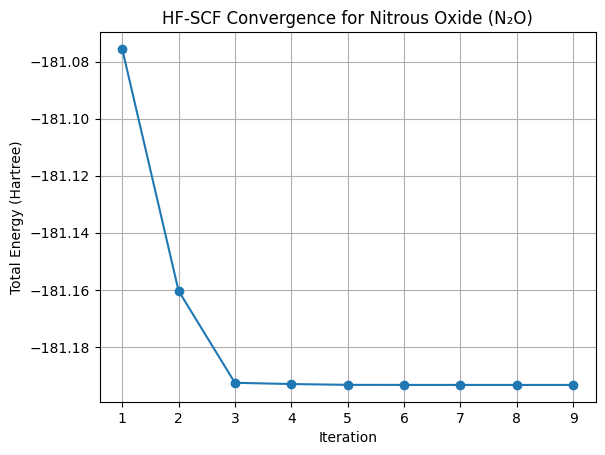

Ground state energy for Nitrous Oxide (N₂O): -181.193323036266 Hartree


In [ ]:
# Visualization of calculation process (Hartree-Fock)
mf = scf.RHF(mol)                         # Set method
conv_data = []                            # Store convergence data
def callback(envs):                       # Callback function to collect convergence information
    conv_data.append(envs['e_tot'])       # Captures energy values at each iteration to track process
mf.callback = callback                    # Set callback directly on the mf object
energy = mf.kernel()                      # Perform HF calculation
energies = conv_data                      # Extract energy values
iterations = range(1, len(energies) + 1)  # Extract iteration numbers
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title(f'HF-SCF Convergence for {molecule}')
plt.grid(True)
plt.show()
print(f"Ground state energy for {molecule}: {energy} Hartree")

**Hartree-Fock (HF):** **Single-Point Energy Calculations:** These calculate the energy and properties *at a fixed geometry*. This is the foundation for everything else. The starting point for many methods. Solves the Schrödinger equation approximately by assuming each electron moves in the *average* field of all other electrons (mean-field approximation). Neglects electron correlation (the instantaneous interaction between electrons). <font color="blue">*Can be, and often is, formulated in second quantization for easier derivation of equations, although it's conceptually simpler in first quantization.*</font>

**Context: The Hartree-Fock (HF) Method**

**1. The Core Concept**
Hartree-Fock is the fundamental "Mean-Field" approximation in quantum chemistry.
* **The Problem:** Electrons interact with each other ($e^- \leftrightarrow e^-$ repulsion), making the N-body Schrödinger equation impossible to solve exactly.
* **The Solution:** HF assumes each electron moves independently in the **average electrostatic field** created by all other electrons and the nuclei.
* **The Wavefunction:** It approximates the total state as a **Slater Determinant** (an antisymmetric product of single orbitals). This satisfies the Pauli Exclusion Principle but ignores "Electron Correlation" (how electrons dance around each other to avoid collisions).



**2. The Fock Operator ($\hat{F}$)**
The energy of this mean-field system is determined by the Fock Operator, which replaces the true Hamiltonian.

$$\hat{F} = \hat{H}_{core} + \hat{J} - \hat{K}$$

* **$\hat{H}_{core}$ (Core Hamiltonian):** The energy of a *single* electron moving in the field of the *nuclei* only.
    * *Includes:* Kinetic Energy ($T$) + Nuclear Attraction ($V$).
* **$\hat{J}$ (Coulomb Operator):** Represents the classical electrostatic repulsion between charge clouds. "I feel the average charge of all other electrons."
* **$\hat{K}$ (Exchange Operator):** A purely quantum mechanical effect with no classical analog. It lowers the energy by keeping electrons of the same spin apart (Pauli repulsion).

**3. The Fock Matrix ($F$)**
To solve this on a computer, we express the operator in a basis set (like `sto-3g`), creating a matrix.
* **Diagonal Elements ($F_{ii}$):** Roughly the energy of an electron in orbital $i$.
* **Off-Diagonal Elements ($F_{ij}$):** Describe the mixing/coupling between orbital $i$ and orbital $j$.
* **Goal:** We want to find a set of coefficients (orbitals) that makes the off-diagonal elements zero (diagonalizing the matrix).

**4. The SCF Algorithm (Self-Consistent Field)**
Crucially, the Fock Matrix **depends on its own solution**. To calculate the repulsion terms ($J$ and $K$), you need to know where the electrons are (the density). But to know where the electrons are, you need to solve the Fock matrix!
* **Step 1:** Guess the orbitals.
* **Step 2:** Build the Fock Matrix ($F$) using that guess.
* **Step 3:** Diagonalize $F$ to get new orbitals.
* **Step 4:** Compare new orbitals to old ones. If they changed, go back to Step 2.
* **Result:** When they stop changing, the field is "Self-Consistent."

**5. Hartree-Fock vs. VQE (The "Missing Piece")**
This is the most important part for your project:
* **Hartree-Fock Energy:** This is the **Upper Limit**. It is the best you can do *without* entanglement/correlation.
* **Correlation Energy:** The difference between the HF energy and the True energy.
    $$E_{corr} = E_{True} - E_{HF}$$
* **Your VQE Code:**
    1.  Starts with the **Hartree-Fock state** ($|1100\dots\rangle$).
    2.  Uses the quantum computer to add **entanglement** (via UCCSD or Ansatz).
    3.  Recovers the **Correlation Energy** that HF missed.



**6. Summary Table**

| Component | Physical Meaning |
| :--- | :--- |
| **Core Hamiltonian** | Electron Kinetic Energy + Attraction to Nuclei. |
| **Coulomb Matrix ($J$)** | "I am repelled by the average charge cloud of others." |
| **Exchange Matrix ($K$)** | "I avoid electrons of the same spin (Pauli)." |
| **Fock Matrix** | Sum of all above: The effective Hamiltonian for one electron. |
| **Result** | A single configuration (Slater Determinant) that minimizes energy. |



**Context: Slater Determinant**

**1. The "Why": The Pauli Exclusion Principle**
Quantum mechanics dictates that electrons are **Fermions**. They must satisfy the Pauli Exclusion Principle:

  * No two electrons can occupy the exact same quantum state.
  * The total wavefunction must be **Antisymmetric**: If you swap two electrons, the wavefunction must flip its sign ($\Psi \rightarrow -\Psi$).

**2. The "What": Mathematical Form**
A simple product of orbitals (Hartree Product) $\phi_1(1)\phi_2(2)$ is not antisymmetric. To fix this, we organize the orbitals into a determinant.

  * **The Slater Determinant** is the simplest mathematical way to write a wavefunction that automatically satisfies antisymmetry.

$$
\Psi(\mathbf{r}_1, \dots, \mathbf{r}_N) = \frac{1}{\sqrt{N!}}
\begin{vmatrix}
\phi_1(\mathbf{r}_1) & \phi_2(\mathbf{r}_1) & \dots & \phi_N(\mathbf{r}_1) \\
\phi_1(\mathbf{r}_2) & \phi_2(\mathbf{r}_2) & \dots & \phi_N(\mathbf{r}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_1(\mathbf{r}_N) & \phi_2(\mathbf{r}_N) & \dots & \phi_N(\mathbf{r}_N)
\end{vmatrix}
$$

**3. Physical Interpretation in Hartree-Fock**

  * **The Baseline:** The Slater Determinant represents the **Mean-Field** solution. It assumes electrons move in the average field of others but do not instantly dodge each other (Zero Correlation).
  * **Exchange Included:** Because of the determinant structure, electrons of the same spin naturally avoid each other (Exchange Interaction is exact in HF).
  * **Correlation Missing:** Electrons of opposite spins don't "see" each other's instantaneous positions.

**4. How it Lives in Your Code (PySCF)**
PySCF never calculates this massive determinant explicitly. It is **Implicit**.

  * **Orbitals (`mf.mo_coeff`):** These are the building blocks ($\phi_i$) of the determinant.
  * **Occupation (`mf.mo_occ`):** Tells you *which* orbitals are inside the determinant (usually the lowest energy ones, 2 electrons per orbital).

**5. Connection to VQE**
This is the bridge to your quantum circuit:

  * **Start Point:** Your VQE circuit starts by preparing the **Slater Determinant** (the Hartree-Fock state).
      * *In Code:* `circuit.append(cirq.X(qubits[i]))` for the occupied orbitals.
  * **Evolution:** The VQE ansatz (UCCSD/HEA) then applies operations to **break** this single determinant structure, creating a superposition of many determinants to capture the missing electron correlation.


*Fiktive Slater-Determinante für zwei Elektronen, die sich auf einer Linie zwischen zwei Atomen bewegen.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/d/da/Slater-Determinant.png)

*Effekte auf ein Hartree-Produkt und eine Slater-Determinante, wenn zwei Teilchen getauscht werden.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Hartree-Products_vs_Slater-Determinants.png/477px-Hartree-Products_vs_Slater-Determinants.png)


In [ ]:
# HF-SCF Core Hamiltonian matrix
# represents one-electron part of molecular Hamiltonian
# = kinetic energy operator of electrons and electrostatic attraction operator between electrons and nuclei
# Core Hamiltonian does not include electron-electron interactions

# Get the core Hamiltonian (kinetic + nuclear attraction)
core_hamiltonian = mf.get_hcore()
print("Core Hamiltonian matrix (Hcore):\n", core_hamiltonian)

Core Hamiltonian matrix (Hcore):
 [[-3.57206530e+02 -1.37885336e+02 -9.32527924e+00 ... -2.77615539e-01
   1.87801990e-01 -2.77614105e-01]
 [-1.37885336e+02 -1.43541757e+02 -3.44838147e+01 ... -5.92248500e-01
   4.00850790e-01 -5.92156820e-01]
 [-9.32527924e+00 -3.44838147e+01 -5.84726840e+01 ... -1.80590738e+00
   1.23604530e+00 -1.80097177e+00]
 ...
 [-2.77615539e-01 -5.92248500e-01 -1.80590738e+00 ... -3.67725389e+01
   3.46944695e-18 -6.20149928e-01]
 [ 1.87801990e-01  4.00850790e-01  1.23604530e+00 ...  3.46944695e-18
  -3.66217754e+01 -1.73472348e-18]
 [-2.77614105e-01 -5.92156820e-01 -1.80097177e+00 ... -6.20149928e-01
  -1.73472348e-18 -3.66310099e+01]]


In [ ]:
# HF-SCF Fock Matrix

# Fock matrix approximates many-electron wavefunction of system (H₂O),
# i.e. approximates interactions between electrons in a system to find an optimal set of orbitals.
# It gives snapshot of molecule electronic structure, incl. energies of molecular orbitals and how they interact or mix

# Get the Fock matrix (core Hamiltonian + electron-electron interaction terms)
fock_matrix = mf.get_fock()
print("Fock Matrix (Hartree-Fock Hamiltonian):\n", fock_matrix)

Fock Matrix (Hartree-Fock Hamiltonian):
 [[-0.26952032 -0.4694773   0.          0.         -0.29232224 -0.57287415
  -0.47752309  0.          0.          0.01409051]
 [-0.4694773  -0.28525187  0.          0.         -0.23467174 -0.47752309
  -0.30857326  0.          0.          0.21190859]
 [ 0.          0.          1.48384683  0.          0.          0.
   0.          0.44417828  0.          0.        ]
 [ 0.          0.          0.          1.48384683  0.          0.
   0.          0.          0.44417828  0.        ]
 [-0.29232224 -0.23467174  0.          0.          1.20567488 -0.01409051
  -0.21190859  0.          0.         -0.56096308]
 [-0.57287415 -0.47752309  0.          0.         -0.01409051 -0.26952032
  -0.4694773   0.          0.          0.29232224]
 [-0.47752309 -0.30857326  0.          0.         -0.21190859 -0.4694773
  -0.28525187  0.          0.          0.23467174]
 [ 0.          0.          0.44417828  0.          0.          0.
   0.          1.48384683  0.      

In [ ]:
print("Fock Matrix Shape:", fock_matrix.shape)
print("Fock Matrix Size:", fock_matrix.size)
print("Fock Matrix Dimension:", fock_matrix.ndim)
print("Fock Matrix Trace:", np.trace(fock_matrix))
print("Fock Matrix Determinant:", np.linalg.det(fock_matrix))
print("Fock Matrix Rank:", np.linalg.matrix_rank(fock_matrix))

Fock Matrix Shape: (10, 10)
Fock Matrix Size: 100
Fock Matrix Dimension: 2
Fock Matrix Trace: 7.237192699539285
Fock Matrix Determinant: -0.00786278789568637
Fock Matrix Rank: 10


In [ ]:
# HF-SCF Molecular Orbital Coefficients for All Orbitals (occupied and unoccupied)

# Retrieve Hartree-Fock orbitals (related to the Slater determinant) - occupied and unoccupied
# Occupied orbitals: contain electrons in Hartree-Fock ground state
# Virtual orbitals: unoccupied in ground state but can be important for excited state or post-Hartree-Fock methods like MP2 or CISD (electronic correlation effects)

# Get the molecular orbitals (which form the Slater determinant)
mo_coeff = mf.mo_coeff  # Coefficients of the molecular orbitals in the atomic basis
mo_energy = mf.mo_energy  # Orbital energies

print("Molecular Orbital Coefficients (MO coefficients):\n", mo_coeff)
print("Molecular Orbital Energies:\n", mo_energy)

Molecular Orbital Coefficients (MO coefficients):
 [[ 0.40366476  0.15024403 -0.70010768 -0.76067424  0.          0.
  -0.44372807  0.          0.          2.68617997]
 [ 0.17376287  1.95865624  0.7263728   1.6173428   0.          0.
   0.22106467  0.          0.          0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.          0.99134997  0.          0.        ]
 [ 0.          0.          0.          0.          0.57904425  0.
   0.          0.          0.99134997  0.        ]
 [ 0.02249745  0.01425354 -0.0112663   0.41021821  0.          0.
   0.72690133  0.          0.          2.02675347]
 [ 0.40366476 -0.15024403 -0.70010768  0.76067424  0.          0.
  -0.44372807  0.          0.         -2.68617997]
 [ 0.17376287 -1.95865624  0.7263728  -1.6173428   0.          0.
   0.22106467  0.          0.         -0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.         -0.99134997  0.          0.       

In [ ]:
# HF-SCF Molecular Orbital Coefficients for only occupied orbitals

# Extract and display the occupied molecular orbitals - used to construct Slater determinant - Only occupied orbitals
# The mo_occ variable stores the occupation numbers, which are usually 2 for occupied orbitals
# in a closed-shell Hartree-Fock calculation (since there are two electrons per orbital in a closed-shell system).
# By identifying which orbitals are occupied using np.where(mo_occ > 0),
# the code extracts the coefficients corresponding to those occupied orbitals and prints them.

mo_coeff = mf.mo_coeff # Get molecular orbital coefficients
mo_occ = mf.mo_occ # Get occupation numbers (from orbitals)
occupied_indices = np.where(mo_occ > 0)[0] # Identify indices of occupied orbitals
occupied_mo_coeff = mo_coeff[:, occupied_indices] # Coefficients of occupied molecular orbitals
print("Occupied Molecular Orbital Coefficients:")
print(occupied_mo_coeff)

Occupied Molecular Orbital Coefficients:
[[ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [ 0.02249745]
 [ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [-0.02249745]]


###### *Static (No Nuclear Motion): Single-Point Energy Calculation: Post-Hartree Fock: **Coupled Cluster** (Post Hartree Fock)*

**Coupled Cluster (CC):** Very accurate (often considered the "gold standard" for single-reference methods). CCSD (singles and doubles), CCSD(T) (includes perturbative triples). CCSD(T) is highly accurate but scales poorly with system size. <font color="blue">*Almost exclusively formulated and implemented in second quantization due to its complexity.*</font>

In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
"""
Very accurate (often considered the "gold standard" for single-reference methods).
CCSD (singles and doubles), CCSD(T) (includes perturbative triples).
CCSD(T) is highly accurate but scales poorly with system size.
Almost exclusively formulated and implemented in second quantization due to its complexity.
"""
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()
ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
print(f"HF-SCF energy: {hf_energy} Hartree")
print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -1.12870009355644
E(CCSD) = -1.163374496404819  E_corr = -0.03467440284837722
CCSD(T) correction = 3.99717015393741e-19
HF-SCF energy: -1.128700093556442 Hartree
CCSD energy: (np.float64(-0.034674402848377216), array([[ 3.39540587e-16, -5.97110968e-03, -2.44502512e-17,
         0.00000000e+00,  0.00000000e+00, -4.15377664e-03,
         0.00000000e+00,  0.00000000e+00,  3.61149362e-18]]), array([[[[-5.34108771e-02, -2.87498266e-17,  4.71221663e-02,
           0.00000000e+00,  0.00000000e+00,  3.54975293e-17,
           0.00000000e+00,  0.00000000e+00, -6.09039779e-03],
         [-2.87498266e-17, -5.07200622e-02, -2.20153962e-17,
           0.00000000e+00,  0.00000000e+00,  1.41940469e-02,
           0.00000000e+00,  0.00000000e+00,  3.01105216e-17],
         [ 4.71221663e-02, -2.20153962e-17, -5.31524971e-02,
           0.00000000e+00,  0.00000000e+00, -6.04008858e-19,
           0.00000000e+00,  0.00000000e+00,  1.04839327e-02],
         [ 0.00000000e+00,  0.0000

###### *Static (No Nuclear Motion): Single-Point Energy Calculation: Post-Hartree Fock: **Møller-Plesset Perturbation** Theory (Post Hartree Fock)*

**Møller-Plesset Perturbation Theory (MPn):** MP2, MP3, MP4... Adds correlation as a perturbation to the HF solution. MP2 is the most common. <font color="blue">*Derivation and implementation significantly simplified by second quantization.*</font>

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
mp2 = mp.MP2(mf) # MP2 single point energy calculation
energy_mp2 = mp2.kernel()
print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -1.12870009355644
E(RMP2) = -1.15507165119134  E_corr = -0.0263715576348957
E(SCS-RMP2) = -1.16034596271832  E_corr = -0.0316458691618748
MP2 energy: -0.026371557634895678 Hartree


###### *Static (No Nuclear Motion): Single-Point Energy Calculation: Post-Hartree Fock: **Configuration Interaction** (Post Hartree Fock)*

**Configuration Interaction (CI):** Builds the wavefunction as a linear combination of determinants, each representing a different electronic configuration. Full CI (FCI) is exact within the chosen basis set but is computationally infeasible except for very small systems. Truncated CI (e.g., CISD - singles and doubles) is more practical. <font color="blue">*Can be formulated in both first and second quantization, but second quantization offers advantages for larger systems and higher excitations.*</font>

In [ ]:
from pyscf import tdscf  # For CIS calculations (using TDHF)
from pyscf import ci     # For CISD calculations
from pyscf import fci    # For FCI calculations

"""
* CIS calculation: PySCF doesn't have a direct ci.CIS module. Instead, we use the Time-Dependent Hartree-Fock (TDHF) approach with the Tamm-Dancoff Approximation (TDA), which is equivalent to CIS for excited states.
* Wavefunction analysis: this is a simplified analysis of the CISD wavefunction by directly summing over the appropriate coefficients.

This script performs:
1. Hartree-Fock (HF) calculation as the reference
2. Configuration Interaction Singles (CIS)
3. Configuration Interaction Singles and Doubles (CISD)
4. Full Configuration Interaction (FCI) - note this is very computationally expensive

The code also analyzes the CISD wavefunction to show the contributions from the reference determinant, single excitations, and double excitations.

A few important notes:
- **CIS is primarily used for excited states, not ground state correlation energy (the first excited state energy is reported)**
- CISD includes single and double excitations and is commonly used for ground state calculations
- FCI is the exact solution within the given basis set but scales factorially with system size
- For larger molecules, you may want to use truncated CI methods or other approaches like CASCI (Complete Active Space CI)
"""

# Step 1: Perform a HF-SCF calculation to obtain the reference wavefunction
mf = scf.RHF(mol)
hf_energy = mf.kernel()
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")

# Step 2: Perform Configuration Interaction calculations

# CIS (Using TDHF which is equivalent to CIS for singlet excited states)
cis_calc = tdscf.TDA(mf)  # TDA approximation is equivalent to CIS
cis_e, cis_v = cis_calc.kernel()
cis_energy = cis_e[0] + hf_energy  # First excited state energy

# CISD
cisd_calc = ci.CISD(mf)
cisd_energy = cisd_calc.kernel()[0]  # Get the ground state energy

# FCI - Note: This can be very computationally expensive
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]

# Print the results
print(f"Molecule: {molecule}")
print(f"Basis Set: {mol.basis}")
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")
print(f"CIS excited state energy: {cis_energy:.8f} Hartree")
print(f"CIS excitation energy: {cis_e[0]:.8f} Hartree")
print(f"CISD correlation energy: {cisd_energy - hf_energy:.8f} Hartree")
print(f"CISD total energy: {cisd_energy:.8f} Hartree")
print(f"FCI correlation energy: {fci_energy - hf_energy:.8f} Hartree")
print(f"FCI total energy: {fci_energy:.8f} Hartree")

# Analyze the CISD wavefunction
cisd_coeff = cisd_calc.ci
print("\nCISD Wavefunction Analysis:")
print(f"Reference determinant weight: {cisd_coeff[0]**2:.6f}")

# Calculate contributions from singles and doubles
#from pyscf.ci import cisd_slow
nelec = mol.nelectron
nocc = nelec // 2
nvir = mf.mo_coeff.shape[1] - nocc

# Get singles and doubles contribution
singles_norm = 0
doubles_norm = 0

# Singles contribution
singles_norm = sum(abs(cisd_coeff[i])**2 for i in range(1, nocc*nvir+1))

# Doubles contribution
doubles_norm = sum(abs(cisd_coeff[i])**2 for i in range(nocc*nvir+1, len(cisd_coeff)))

print(f"Singles contribution: {singles_norm:.6f}")
print(f"Doubles contribution: {doubles_norm:.6f}")
print(f"Total normalization check: {cisd_coeff[0]**2 + singles_norm + doubles_norm:.6f}")

converged SCF energy = -1.12870009355644
HF-SCF energy: -1.12870009 Hartree
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]
E(RCISD) = -1.163374490318234  E_corr = -0.03467439676179211
Molecule: Hydrogen (H₂)
Basis Set: cc-pvdz
HF-SCF energy: -1.12870009 Hartree
CIS excited state energy: -0.61142874 Hartree
CIS excitation energy: 0.51727136 Hartree
CISD correlation energy: 1.09402570 Hartree
CISD total energy: -0.03467440 Hartree
FCI correlation energy: -0.03467440 Hartree
FCI total energy: -1.16337449 Hartree

CISD Wavefunction Analysis:
Reference determinant weight: 0.983138
Singles contribution: 0.000052
Doubles contribution: 0.016758
Total normalization check: 0.999948


###### *Static (No Nuclear Motion): **Geometry Optimization** (HF or DFT)*

**Full Geometry Optimization:** **Static Calculations (No Nuclear Motion Considered *During* the Calculation)** (*See Born-Oppenheimer Approximation*). Finds the minimum energy structure (equilibrium geometry) of a molecule or system. This is an iterative process that uses the forces (calculated from the energy gradient) to adjust the nuclear positions until a minimum is reached. Uses the same underlying electronic structure methods as single-point calculations (HF, DFT, etc.). The same notes about first vs. second quantization apply as for the corresponding single-point method.

In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

# Define the molecule with a rough guess for geometry (initial atomic positions)
# These positions don't need to be exact, as the optimization will refine them
mol.atom = mol.atom
mol.basis = mol.basis
mol.build()

# Take molecule including basis set defined from `mol.build()`
mf = dft.RKS(mol)     # Perform geometry optimization using DFT (Restricted Kohn-Sham)
mf.xc = 'b3lyp'       # Define the exchange-correlation functional
mol_eq = optimize(mf)

# Print optimized coordinates. This geometry corresponds to lowest energy configuration found during optimization process
print("Optimized Geometry (in Angstroms):")
print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-ae64ed8a-9a3a-4ae4-9549-db57adcde7fa.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.740000    0.000000  0.000000  0.000000

WARN: Unable to to identify input symmetry using original axes.
Different symmetry axes will be used.


WARN: Mole.unit (angstrom) is changed to Bohr

converged SCF energy = -1.17328112090857
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0159964150
1 H     0.0000000000     0.0000000000    -0.0159964150
----------------------------------------------
cycle 1: E = -1.17328112091  dE = -1.17328  norm(grad) = 0.0226223


Step    0 : Gradient = 1.600e-02/1.600e-02 (rms/max) Energy = -1.1732811209
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.91394e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010814    0.000000  0.000000  0.359186
   H   0.000000   0.000000   0.750814    0.000000  0.000000  0.380814
converged SCF energy = -1.17360206558998
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000664006
1 H     0.0000000000     0.0000000000    -0.0000664006
----------------------------------------------
cycle 2: E = -1.17360206559  dE = -0.000320945  norm(grad) = 9.39046e-05


Step    1 : Displace = 1.081e-02/1.081e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 6.640e-05/6.640e-05 (rms/max) E (change) = -1.1736020656 (-3.209e-04) Quality = 0.982
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010859    0.000000  0.000000  0.369955
   H   0.000000   0.000000   0.750859    0.000000  0.000000  0.370045
converged SCF energy = -1.17360207162442
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000045661
1 H     0.0000000000     0.0000000000    -0.0000045661
----------------------------------------------
cycle 3: E = -1.17360207162  dE = -6.03443e-09  norm(grad) = 6.45747e-06


Step    2 : Displace = 4.507e-05/4.507e-05 (rms/max) Trust = 1.414e-01 (+) Grad = 4.566e-06/4.566e-06 (rms/max) E (change) = -1.1736020716 (-6.034e-09) Quality = 1.067
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.354 seconds


Optimized Geometry (in Angstroms):
[[ 0.          0.         -0.71971902]
 [ 0.          0.          0.71971902]]


<font color="blue">*Geometry Optimization*
> * Not a single-point calculation: In geometry optimization, the goal is to find the lowest-energy structure of a molecule or system by adjusting the positions of the atoms iteratively.
* Process: Starting from an initial geometry, the system’s energy is calculated, and the forces on the atoms are used to adjust the geometry. This process is repeated many times, recalculating the energy and forces at each step, until the forces on the atoms reach a minimum (i.e., no further energy reduction is possible).
* Multiple calculations: Since the geometry is updated at each step, multiple energy and force calculations are needed. It involves a series of steps where the atomic positions are changed based on gradients (forces), and the energy is recalculated until convergence.

* In a **geometry optimization**, the goal is to find the most stable molecular structure by minimizing the total energy.
* The positions of the atoms are iteratively adjusted, and the energy is recalculated at each step, until the structure converges to a minimum energy configuration (local minimum).
* **Example**: You might start with a rough guess for the molecular geometry, and the optimization procedure will adjust the bond lengths and angles to find the lowest energy conformation.

* **Hartree-Fock (HF)**: The Hartree-Fock method can be used for geometry optimization, but it often lacks the accuracy needed for real systems due to missing electron correlation. It's more suitable for qualitative insights or as a starting point for more accurate methods.

###### *Static (No Nuclear Motion):* ***Calculate Excited States***

In [ ]:
# Calculate excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -1.12870009355644
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]

** Singlet excitation energies and oscillator strengths **
Excited State   1:  A1u     14.07567 eV     88.08 nm  f=0.6152
Excited State   2:  A1g     21.45479 eV     57.79 nm  f=0.0000
Excited State   3:  A1u     32.30709 eV     38.38 nm  f=0.2024


**Excited State Calculations:** Calculates properties of electronically excited states.
*   **Time-Dependent Density Functional Theory (TD-DFT):** The most common method for calculating excitation energies and simulating UV-Vis spectra. An extension of DFT to time-dependent systems. <font color="blue">*Typically formulated in first quantization (using time-dependent Kohn-Sham orbitals).*</font>
*   **Configuration Interaction Singles (CIS):** A simple, HF-like method for excited states. Qualitatively correct, but often not quantitatively accurate. <font color="blue">*Can be formulated in both, but second quantization is common.*</font>
*   **Equation-of-Motion Coupled Cluster (EOM-CC):** Highly accurate, but computationally expensive. <font color="blue">*Almost exclusively formulated and implemented in second quantization.*</font>
*   **Complete Active Space Self-Consistent Field (CASSCF):** A multireference method, essential for systems with significant multireference character (e.g., bond breaking, diradicals). Requires careful selection of an "active space" of orbitals. <font color="blue">*Can be formulated in both, but second quantization is often preferred for larger active spaces.*</font>
*   **CASPT2:** Perturbation theory on top of CASSCF to include dynamic correlation, generally improving upon the CASSCF results. <font color="blue">*Derivation and implementation significantly simplified by second quantization.*</font>
*   **Direct Diagonalization of the Hamiltonian:** Although rarely used for many-electron systems, it's conceptually important. It involves constructing the Hamiltonian matrix in a chosen basis and finding its eigenvalues (energies) and eigenvectors (wavefunctions). This is, in principle, the most direct way to solve the Schrödinger equation, but the matrix size becomes prohibitively large very quickly. <font color="blue">*Conceptually in first quantization, but practically limited by matrix size.*</font>

###### *Static (No Nuclear Motion): **Vibrational Frequency Spectroscopy** (Hessian Calculation)*

Difference between **Electronic** and **Vibrational** spectroscopy, and how your **Harmonic Oscillator** model fits in.

**1. What is a "Vibrational Mode"?**

A vibrational mode is a specific, independent pattern in which a molecule dances. It is not random; it is a quantized "shape" of motion.

  * **The Rule:** A molecule with $N$ atoms has **$3N - 6$** vibrational modes (or $3N - 5$ if it is linear like CO₂).
  * **Example (Water, $H_2O$):** It has 3 atoms, so $3(3) - 6 = 3$ modes.
    1.  **Symmetric Stretch:** Both H atoms move out.
    2.  **Asymmetric Stretch:** One H moves in, the other moves out.
    3.  **Bend:** The angle flutters open and closed.

**2. Vibrational vs. Electronic Spectroscopy**

This was your key question. The distinction is about **"Who is moving?"** and **"How much energy does it take?"**

| Feature | **Electronic Spectroscopy** | **Vibrational Spectroscopy** |
| :--- | :--- | :--- |
| **What moves?** | **Electrons** jump between orbitals. | **Nuclei** oscillate (wiggle) in a potential well. |
| **Energy Scale** | **High Energy** (\~eV) <br> UV / Visible Light | **Low Energy** (\~0.1 eV) <br> Infrared (IR) Light |
| **The "Landscape"** | Electrons **create** the landscape (Potential Energy Surface). | Nuclei **move on** that landscape. |
| **Analogy** | Jumping from the ground floor to the 2nd floor of a building. | Running back and forth *inside* a room on the ground floor. |

  * **Do electrons matter for vibrations?** Yes, but only because they create the "stiffness" of the bond (the spring). They are the *reason* the spring exists, but they are not the ones vibrating.

**3. The "Ball on a Hill" Model (Harmonic Oscillator)**

Your intuition about the **Quantum Harmonic Oscillator** is 100% correct. It is the mathematical model for **one single vibrational mode**.

Every "wiggle" (like the O-H stretch) acts exactly like a ball rolling in a parabolic valley.

**Translating Physics to Your Code**

You identified the two key parameters perfectly:

**A. `c_pot` = Stiffness ($k$) = The Shape of the Hill**

  * **Physics:** This represents the chemical bond strength.
  * **Visual:**
      * **High `c_pot` (Stiff Bond):** A steep, narrow canyon. The ball oscillates very fast. (Example: O-H Stretch).
      * **Low `c_pot` (Weak Bond):** A shallow, wide valley. The ball oscillates slowly. (Example: Hydrogen Bond or O-H-O Bend).

**B. `c_x` = Inverse Mass ($1/m$) = The "Hopping" Ability**

  * **Physics:** This represents the kinetic energy term ($p^2/2m$).
  * **Visual:**
      * **High `c_x` (Light Atom):** A light particle (like Hydrogen) "hops" easily between grid points. It is agile and fast.
      * **Low `c_x` (Heavy Atom):** A heavy particle (like Oxygen) struggles to hop. It has high inertia.

**4. Synthesis: How to "Tune" Your Molecule**

If you want to use your Quantum Harmonic Oscillator code to simulate specific parts of a water molecule, here is how you would tune your parameters:

| Vibrational Mode | Description | Mass ($1/c_x$) | Stiffness ($c_{pot}$) | Resulting Frequency |
| :--- | :--- | :--- | :--- | :--- |
| **O-H Stretch** | Hydrogen pulling away from Oxygen. | **Light** (High `c_x`) | **Very Stiff** (High `c_pot`) | **High Frequency** (Fast vibration) |
| **H-O-H Bend** | The angle opening/closing. | **Medium** (Medium `c_x`) | **Floppy** (Low `c_pot`) | **Medium Frequency** |
| **O-O Motion** | Two water molecules bumping. | **Heavy** (Low `c_x`) | **Weak** (Very Low `c_pot`) | **Low Frequency** (Slow rumble) |

**Final Takeaway:**
You are no longer just solving a random math equation. When you change `c_pot` and `c_x` in your code, you are effectively **designing a molecule**, deciding how heavy its atoms are and how strong its bonds are\!

**Vibrational Frequency Calculations (Hessian Calculation):** Calculates the vibrational modes and frequencies of a molecule at a stationary point (usually a minimum or transition state). This requires calculating the second derivatives of the energy with respect to nuclear positions (the Hessian matrix). Used for:
*   Confirming that a geometry is a true minimum (all frequencies are real) or a transition state (one imaginary frequency).
*   Simulating IR and Raman spectra.
*   Calculating zero-point vibrational energies (ZPVE).

The same notes about first vs. second quantization apply as for the corresponding single-point method from which the Hessian is derived.

<font color="blue">**Spectroscopy Simulations:**</font>

*   **IR Spectroscopy:** Calculated from vibrational frequencies and intensities. The notes about first vs. second quantization generally follow the underlying method used to calculate the relevant properties (e.g., vibrational frequencies, excitation energies). <font color="blue">For instance, IR spectroscopy based on a DFT Hessian calculation would typically be considered a first-quantization approach.</font>
*   **Raman Spectroscopy:** Calculated from vibrational frequencies and Raman activities. <font color="blue">Same as IR above (first-quantization).</font>
*   **UV-Vis Spectroscopy:** Calculated from electronic excitation energies and oscillator strengths (usually using TD-DFT). Same as IR above.
*   **NMR Spectroscopy:** Calculated using methods that determine the response of the system to magnetic fields (e.g., GIAO-DFT). <font color="blue">Same as IR above (first-quantization).</font>
*   **X-Ray Absorption Spectroscopy (XAS) and X-ray Emission Spectroscopy (XES):** Requires specialized methods to handle core-level excitations. <font color="blue">Same as IR above (first-quantization).</font>

###### ***Electronic Spectroscopy*** *(Emission and Absorption)*

converged SCF energy = -1.12870009355644


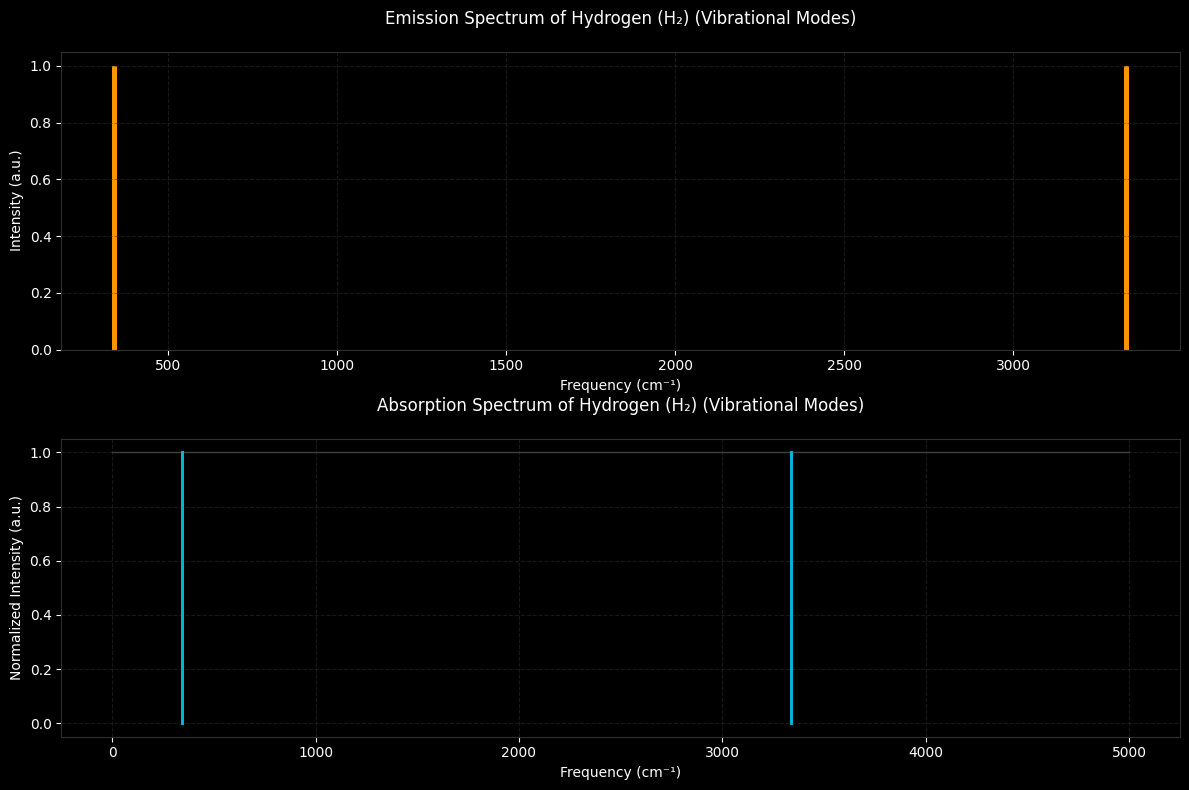

In [ ]:
# Emission and Absorption Spectra (Electronic Frequencies / Transitions)

mf = scf.RHF(mol)                                     # Perform a ground-state calculation for molecular vibrational frequencies
mf.kernel()
hess = hessian.RHF(mf).kernel()                       # Calculate the Hessian matrix (force constants)
frequencies = np.linalg.eigvalsh(hess)                # Diagonalize the Hessian to get vibrational frequencies
frequencies = np.sqrt(np.abs(frequencies)) * 5140.48  # Conversion factor to cm^-1 (more accurate)
frequencies = frequencies[(frequencies > 0) & (frequencies < 5000)]  # Filter out non-physical (imaginary) frequencies and limit to realistic range

# Plot stlyes
EMISSION_COLOR = '#ff9500'  # Bright orange
ABSORPTION_COLOR = '#00b4d8'  # Bright blue
BASELINE_COLOR = '#404040'  # Dark gray
GRID_COLOR = '#303030'  # Slightly lighter gray for grid
plt.figure(figsize=(12, 8), facecolor='black') # Create figure with dark background
plt.style.use('dark_background') # Set the style to dark background

# Emission Spectrum
plt.subplot(2, 1, 1)
plt.bar(frequencies, height=1.0, width=15.0, color=EMISSION_COLOR, alpha=0.8)
plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Emission Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Absorption Spectrum
plt.subplot(2, 1, 2)
# Create baseline
plt.plot(np.linspace(0, 5000, 1000), np.ones(1000),
         color=BASELINE_COLOR, linewidth=1)

# Plot absorption lines with gradient effect
for freq in frequencies:
    y = np.linspace(0, 1, 100)
    x = np.ones_like(y) * freq
    plt.plot(x, y, color=ABSORPTION_COLOR,
            alpha=0.8, linewidth=2)

plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Normalized Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Absorption Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Set figure background to black
plt.gcf().patch.set_facecolor('black')

plt.show()